In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import gcf
import numpy as np 
from einops import rearrange
from sklearn import cluster

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.cdnmf_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition._nmf import NMF
import math
import seaborn as sns
from matplotlib.patches import Rectangle

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique 
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3,get_indices_2ormore#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder



/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')

annotation/ccf_2017


In [4]:
#load data
def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    return(tr_err, te_err)

def fix_pdcsv(csv):
    
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

def fill_df_na(data, indices):
    
    for i in range(indices.shape[0]):
        data.iloc[indices[i,0],indices[i,1]] = np.nan
        
    return(data)

def get_colors(structures, palettes, alpha):
    
    strs_unique = np.unique(structures)
    nstr = len(strs_unique)
    cs = sns.color_palette("Spectral", nstr)
    
    #print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
    cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
    color_str = {}
    for i in range(nstr):
        #print(i)
        color_str[strs_unique[i]] = cs_alphas[i]
    #print(color_str['CB'])
    #print(color_str)
    output = np.zeros((len(structures),4), dtype  =float)
    for i in range(len(structures)):
        #print(np.asarray(color_str[structures[i]]))
        output[i] = np.asarray(color_str[structures[i]])
        
    return(output,color_str)

wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/ELLeafsmoothsummarysurface_leafsource_summarytarget_v3/elsummarymodel_leafsource_summarytarget_wt_v3.csv',  header=[0,1])
wt_conn = fix_pdcsv(wt_conn)
dists = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances.csv',  header=[0,1])
dists = fix_pdcsv(dists)
wt_conn = wt_conn.loc[dists.index]
wt_conn = wt_conn.loc[:,dists.columns]

In [5]:
#get ontological order structures and leaf major regions
oos_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/oos_ic_majors_v3.npy')
ool_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ool_majors_names_v3.npy')

ccol,ccol_dict = get_colors(np.asarray(oos_ic_majors), sns.color_palette("Spectral", 12), 1.)
crow,crow_dict = get_colors(np.asarray(ool_ic_majors), sns.color_palette("Spectral", 12), 1.)
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])
low_values = np.asarray(np.where(dists < 15)).transpose()

In [6]:
# g= sns.clustermap(dists, col_cluster = False, row_cluster = False, col_colors=ccol, 
#                   row_colors = crow, figsize = (15,15), cmap = 'viridis')


In [7]:
g= sns.clustermap(dists, col_cluster = False, row_cluster = False, col_colors=ccol, 
                  row_colors = crow, figsize = (15,15), cmap = 'viridis')
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 30)
g.ax_heatmap.set_ylabel('Leaf Sources (n = 564)', fontsize = 30)
#g.set_title('Source-target distances', fontsize = 40)
ax = gcf().add_axes((0.6,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=ccol_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.14, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Distance ' +  r'$(100 \mu m)$', rotation=0, fontsize = 20)
g.ax_cbar.set_position([1.0,0.4,.1,.1])
g.ax_cbar.axhline(15, color = 'red', linewidth = 5)
g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 30, color  = 'fuchsia')
g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 30, color  = 'purple')
g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)
g.ax_col_colors.set_title('Distances b/w structures', fontsize = 40)
for i in range(low_values.shape[0]):
    #print(i)
    g.ax_heatmap.add_patch(Rectangle((low_values[i][1],low_values[i][0]), 1, 1, fill=False, edgecolor='red', lw=.15))


Error in callback <function flush_figures at 0x125af6c20> (for post_execute):


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/IPython/core/events.py", line 88, in trigger
    func(*args, **kwargs)
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py", line 117, in flush_figures
    return show(True)
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/IPython/core/display.py", line 313, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "</Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/py

KeyboardInterrupt: 

In [11]:
from sklearn.decomposition import TruncatedSVD

In [12]:
#ids = np.where(rss > 0.)[0]

In [13]:
# svd = TruncatedSVD(n_components=15)
# svd.fit(wt_conn.iloc[ids])

In [ ]:
#svd.components_[1] 

In [ ]:
#sns.heatmap(np.log(svd.components_), vmin = -9, vmax=  0)

In [23]:
rss.shape

(564,)

In [14]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]

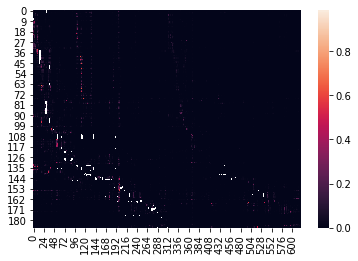

In [24]:
sns.heatmap(data[ids])

In [160]:
train_err = []
test_err = []
nrep = 10
tr_results = np.zeros((nrep,25))
te_results = np.zeros((nrep,25))
for n in range(1,25):
    print(n)
    for r in range(nrep):
        #print(r)
        tr_results[r,n] , te_results[r,n] = cv_nmf_missing(data, n_components = n ,alpha=0.0, l1_ratio = 1.,p_holdout = .3)

1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

KeyboardInterrupt: 

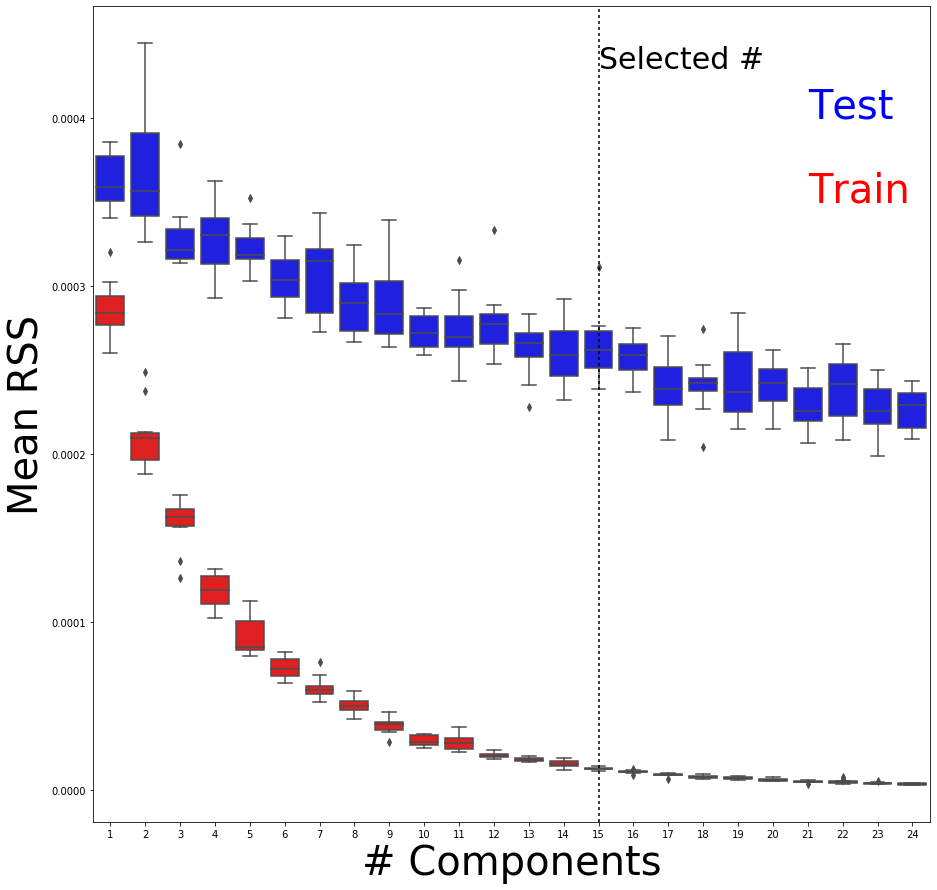

In [108]:
fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = te_results[:,1:], ax=  ax, color= 'blue')
sns.boxplot( data = tr_results[:,1:], ax=  ax, color= 'red')
ax.set_xticklabels(list(range(1,25)))
ax.axvline(14, color='k', dashes=[2,2])
ax.text(20,.0004, 'Test',color = 'blue', fontsize = 40)
ax.text(20,.00035, 'Train',color = 'red', fontsize = 40)
ax.text(14,.00043, 'Selected #', fontsize = 30)
ax.set_ylabel('Mean RSS', fontsize = 40)
ax.set_xlabel('# Components', fontsize = 40)
#fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/figures/test_train.png', bbox_inches = 'tight',
#    pad_inches = 0)
#ax.legend()

In [15]:
ncomp = 15
nreps = 10
components = np.zeros((nreps,ncomp,621))
for r in range(nreps):
    print(r)
    nmf = NMF(n_components=ncomp, alpha=.02, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
    nmf.fit(data[ids])
    components[r] = nmf.components_

0


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


5


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


7


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


8


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


9


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [21]:
ids.shape

(187,)

In [19]:
data[ids]

array([[           nan, 6.23434447e-02, 8.20779622e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [           nan, 1.11824507e-01,            nan, ...,
        4.42863576e-07, 7.48762152e-08, 6.79039609e-05],
       [           nan, 5.69264637e-03,            nan, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.43951325e-05, 7.94917405e-03, 3.00634242e-03, ...,
        1.49491369e-03, 1.57815655e-04, 0.00000000e+00],
       [0.00000000e+00, 5.08594734e-04, 2.59720400e-04, ...,
        3.75356823e-02, 1.67980068e-03, 7.52135704e-04],
       [5.76995332e-19, 8.86363421e-18, 9.14880545e-08, ...,
        2.98076684e-05, 1.42241176e-18, 6.78343044e-20]])

In [27]:
combined = rearrange(components, 'r c p -> (r c) p')
nclusts = np.asarray([15,20,25,30,35])
nreps_cluster = 25

In [30]:
from sklearn import metrics
from collections import Counter

In [31]:
results = np.zeros(nclusts.shape[0])
for d in range(len(nclusts)):
    print(d)
    nclust = nclusts[d]
    cluster_reps = np.zeros((nreps_cluster,combined.shape[0]))
    for c in range(nreps_cluster):
        
        kmeans  = cluster.KMeans(n_clusters=nclust)
        kmeans.fit(combined)
        clusts = kmeans.labels_[kmeans.labels_.argsort()]
        cluster_reps[c] = kmeans.labels_
        
        
        rands = np.zeros((nreps_cluster,nreps_cluster))
        rands[:] = np.nan
    for i in range(nreps_cluster):
        print(i)
        for j in range(nreps_cluster):
            if i != j:
                rands[i,j] = metrics.adjusted_rand_score(cluster_reps[i], cluster_reps[j])
                    
    results[d] = np.nanmean(rands)
        #print(kmeans.inertia_)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [32]:
results

array([0.86616804, 0.93664971, 0.94616968, 0.92288997, 0.91860124])

In [33]:
nclust = 25
kmeans  = cluster.KMeans(n_clusters=nclust)
kmeans.fit(combined)
clusts = kmeans.labels_[kmeans.labels_.argsort()]
cclusts = Counter(clusts)
topclusts  = np.asarray(list(cclusts.keys()))[np.asarray(list(cclusts.values())).argsort()][-15:]

In [34]:
top_clust_inds = np.where(np.isin(clusts, topclusts))[0]

In [35]:
# #multiind cre_inds, layers, summary
# sel_labels = np.zeros(150)
# sel_labels[top_clust_inds] = 1
# rep_labels = np.asarray(np.repeat(list(range(10)),15)[kmeans.labels_.argsort()], dtype = str)
# clust_labels = np.asarray(clusts, dtype = str)
# row_multi_ind = np.vstack([sel_labels,rep_labels,clust_labels])
# row_multi_ind = np.asarray(row_multi_ind, dtype = str)
# row_multi_ind_tuples = list(zip(*row_multi_ind))
# row_multi_ind_tuples = pd.MultiIndex.from_tuples(row_multi_ind_tuples, names=['Top 15 basis','Replicate', 'Cluster'])

# sel_labels = row_multi_ind_tuples.get_level_values('Top 15 basis')
# sel_pal = sns.color_palette("cubehelix", n_colors = np.unique(sel_labels).shape[0])
# sel_lut = dict(zip(map(str, np.unique(sel_labels)), sel_pal))
# sel_colors = pd.Series(sel_labels, index=row_multi_ind_tuples).map(sel_lut)

# rep_labels = row_multi_ind_tuples.get_level_values("Replicate")
# #rep_labels = pd.Index(rep_labels, dtype = object)#pd.I(rep_labels, index=  np.asarray( list(range(150)) ,dtype = object))
# rep_pal = sns.color_palette("cubehelix", n_colors = np.unique(rep_labels).shape[0])
# rep_lut = dict(zip(map(str, np.unique(rep_labels)), rep_pal))
# rep_colors = pd.Series(rep_labels, index=row_multi_ind_tuples).map(rep_lut)


# #clust_labels = pd.DataFrame(clust_labels, index=  np.asarray( list(range(150)) ,dtype = object))
# clust_labels = row_multi_ind_tuples.get_level_values("Cluster")
# #clust_labels= pd.Index(clust_labels, dtype = object)
# clust_pal = sns.color_palette("Paired", np.unique(clust_labels).shape[0]) #sns.cubehelix_palette(summary_labels.unique().size, light=.9, dark=0.1, reverse=False, start=0, rot=-1, hue = 1)#sns.cubehelix_palette(summary_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
# clust_lut = dict(zip(map(str, np.unique(clust_labels)), clust_pal))
# clust_colors = pd.Series(clust_labels, index=row_multi_ind_tuples).map(clust_lut)

# arr = np.zeros((150,2), dtype = object)
# arr[:,0] = rep_colors
# arr[:,1] = clust_colors
# combined_colors = pd.DataFrame(arr, index = clust_colors.index)

# toplot = pd.DataFrame(np.log(combined[kmeans.labels_.argsort()]), index= combined_colors.index)

# fig, ax = plt.subplots(figsize = (15,15))
# sns.heatmap(toplot , vmin = -6, vmax= 0, ax = ax)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


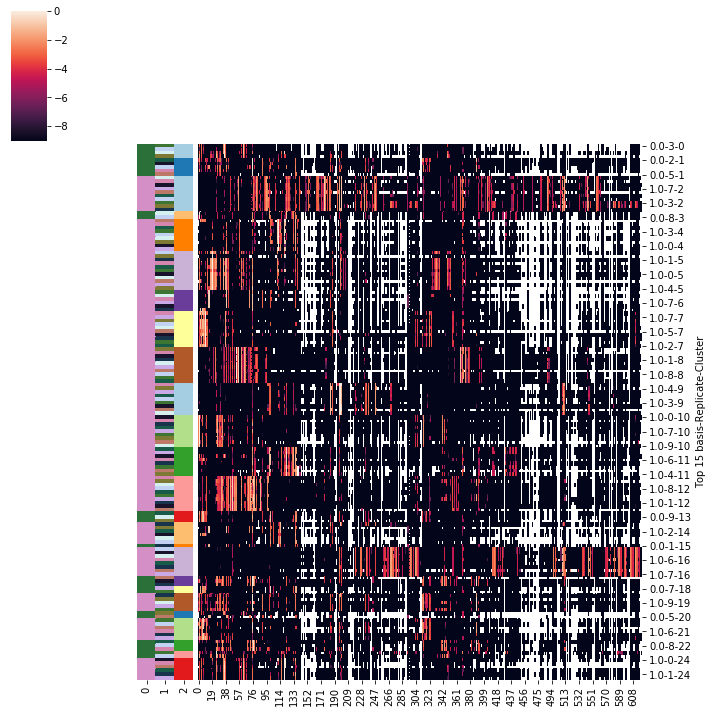

In [36]:

#multiind cre_inds, layers, summary
sel_labels = np.zeros(150)
sel_labels[top_clust_inds] = 1
rep_labels = np.asarray(np.repeat(list(range(10)),15)[kmeans.labels_.argsort()], dtype = str)
clust_labels = np.asarray(clusts, dtype = str)
row_multi_ind = np.vstack([sel_labels,rep_labels,clust_labels])
row_multi_ind = np.asarray(row_multi_ind, dtype = str)
row_multi_ind_tuples = list(zip(*row_multi_ind))
row_multi_ind_tuples = pd.MultiIndex.from_tuples(row_multi_ind_tuples, names=['Top 15 basis','Replicate', 'Cluster'])

sel_labels = row_multi_ind_tuples.get_level_values('Top 15 basis')
sel_pal = sns.color_palette("cubehelix", n_colors = np.unique(sel_labels).shape[0])
sel_lut = dict(zip(map(str, np.unique(sel_labels)), sel_pal))
sel_colors = pd.Series(sel_labels, index=row_multi_ind_tuples).map(sel_lut)

rep_labels = row_multi_ind_tuples.get_level_values("Replicate")
#rep_labels = pd.Index(rep_labels, dtype = object)#pd.I(rep_labels, index=  np.asarray( list(range(150)) ,dtype = object))
rep_pal = sns.color_palette("cubehelix", n_colors = np.unique(rep_labels).shape[0])
rep_lut = dict(zip(map(str, np.unique(rep_labels)), rep_pal))
rep_colors = pd.Series(rep_labels, index=row_multi_ind_tuples).map(rep_lut)


#clust_labels = pd.DataFrame(clust_labels, index=  np.asarray( list(range(150)) ,dtype = object))
clust_labels = row_multi_ind_tuples.get_level_values("Cluster")
#clust_labels= pd.Index(clust_labels, dtype = object)
clust_pal = sns.color_palette("Paired", np.unique(clust_labels).shape[0]) #sns.cubehelix_palette(summary_labels.unique().size, light=.9, dark=0.1, reverse=False, start=0, rot=-1, hue = 1)#sns.cubehelix_palette(summary_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
clust_lut = dict(zip(map(str, np.unique(clust_labels)), clust_pal))
clust_colors = pd.Series(clust_labels, index=row_multi_ind_tuples).map(clust_lut)

arr = np.zeros((150,3), dtype = object)
arr[:,0] = sel_colors
arr[:,1] = rep_colors
arr[:,2] = clust_colors
combined_colors = pd.DataFrame(arr, index = clust_colors.index)

toplot = pd.DataFrame(np.log(combined[kmeans.labels_.argsort()]), index= combined_colors.index)

#fig, ax = plt.subplots(figsize = (15,15))
sns.clustermap(toplot , vmin = -9, vmax= 0, row_cluster=False, col_cluster=False, row_colors=combined_colors)

In [44]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


In [ ]:
archetypes = np.zeros((15,621))
for c in range(15):
    archetypes[c] = np.median(combined[np.where(kmeans.labels_ == topclusts[c])], axis = 0)
    
toplot = np.log(archetypes)
toplot[np.where(toplot< -9)] = -9

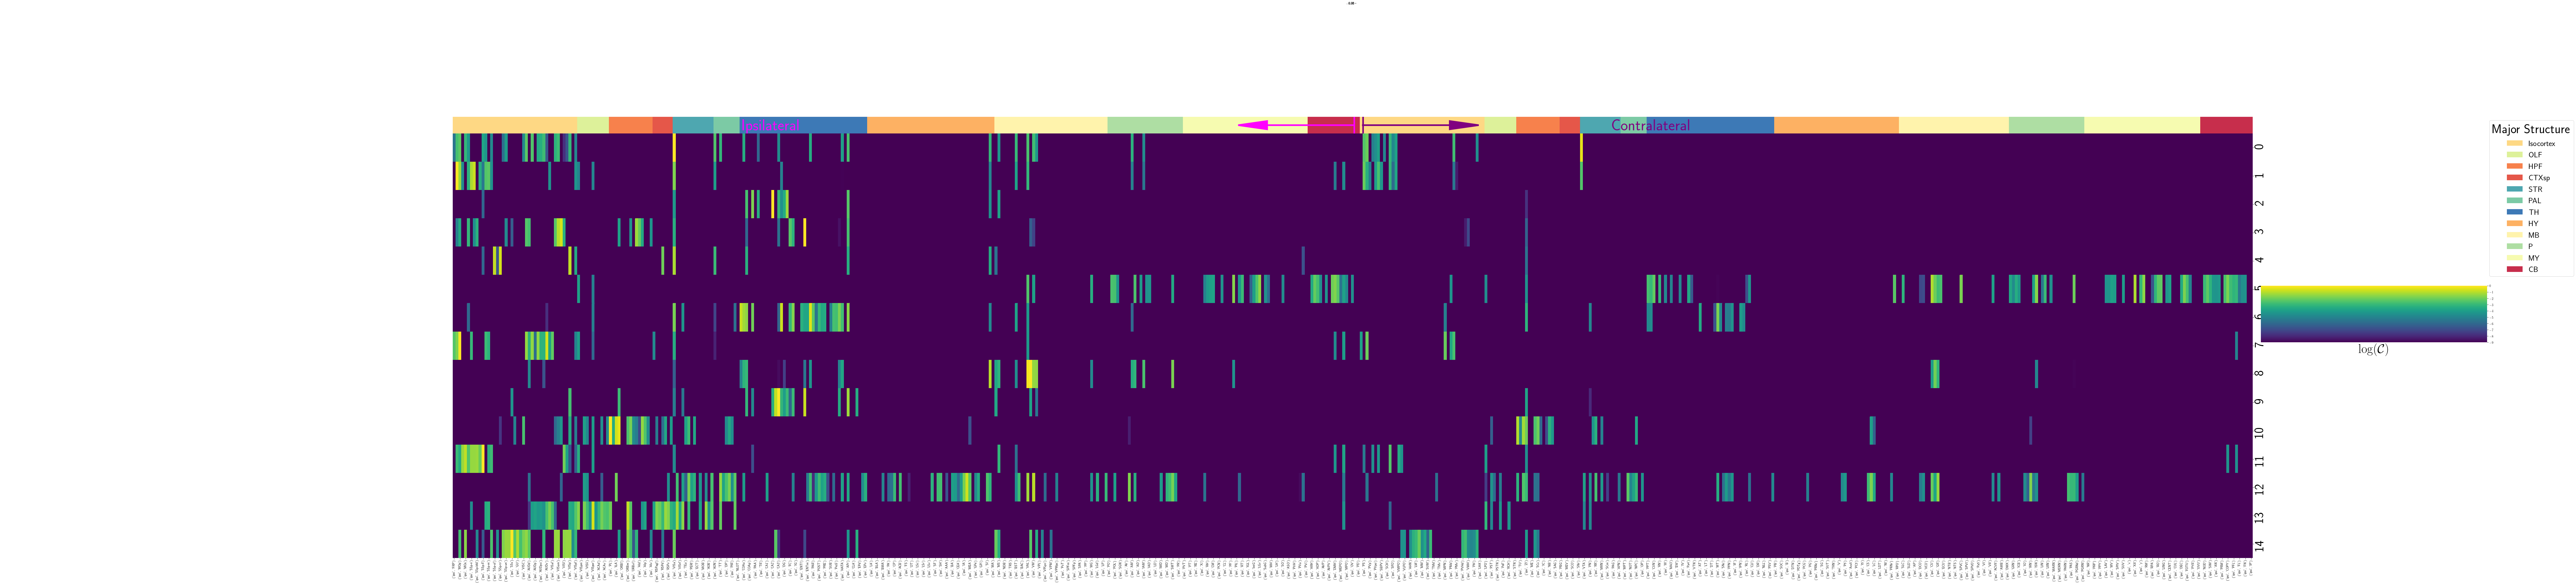

In [131]:
g= sns.clustermap(toplot, 
                  vmin = -9,
                  figsize = (100,25),
                  vmax=  0,
                  cmap = 'viridis',
                  col_cluster=False,
                  row_cluster=False,
                  col_colors=ccol)
#g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xticklabels(wt_conn.columns, fontsize = 10)
g.ax_col_colors.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 40)
ax = gcf().add_axes((0.6,1.,0.,0.))
ax.xaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=ccol_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.14, .8), bbox_transform=gcf().transFigure, fontsize = 25,title_fontsize=40)    
g.ax_heatmap.tick_params(axis='y', labelsize=40)
g.ax_cbar.set_xlabel(r"$\log (\mathcal C)$", rotation=0, fontsize = 40)
g.ax_cbar.set_position([1.0,0.4,.1,.1])
g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 50, color  = 'fuchsia')
g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 50, color  = 'purple')
g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)
g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/H_wt', pad_inches = 0)


In [71]:
from sklearn.decomposition import non_negative_factorization

In [132]:
#W = nmf.fit_transform(data[ids])
#sns.heatmap(np.log(W @ nmf.components_), vmin = -9, vmax = 0)

In [133]:
#sns.heatmap(np.log(nmf.inverse_transform(nmf.components_.transpose())), vmin = -9, vmax = 0)

In [58]:
W, H, n_iter = non_negative_factorization(data[ids], n_components=15, init='custom', solver = 'mu',random_state=0, update_H=False, H=archetypes)
#print(W)
#print(H)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [116]:
wt_conn.shape

(564, 621)

In [120]:
#summary_ontology = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ool_ic_majors_v3.npy')

In [118]:
summary_ontology.shape

(621,)

In [114]:
wt_conn_sub = wt_conn.iloc[ids]

In [115]:
#get layers (inelegant)
layers= np.zeros(wt_conn_sub.shape[0], dtype = object)
for i in range(wt_conn_sub.shape[0]):
    if np.asarray(list(wt_conn_sub.index))[i][-3:] == '2/3':
        layers[i] = '2/3'
    if np.asarray(list(wt_conn_sub.index))[i][-1:] == '1':
        layers[i] = '1'
    if np.asarray(list(wt_conn_sub.index))[i][-1:] == '4':
        layers[i] = '4'
    if np.asarray(list(wt_conn_sub.index))[i][-1:] == '5':
        layers[i] = '5'    
    if np.asarray(list(wt_conn_sub.index))[i][-2:] == '6a':
        layers[i] = '6a' 
        #print('6a')
    if np.asarray(list(wt_conn_sub.index))[i][-2:] == '6b':
        layers[i] = '6b'

In [121]:
# #multiind cre_inds, layers, summary
# row_multi_ind = np.vstack([major_inds,summary_comb,layers])
# row_multi_ind = np.asarray(row_multi_ind)
# row_multi_ind_tuples = list(zip(*row_multi_ind))
# row_multi_ind_tuples = pd.MultiIndex.from_tuples(row_multi_ind_tuples, names=['Cre', 'Summary Structure','Layer'])

# major_labels = row_multi_ind_tuples.get_level_values("Cre")
# major_pal = sns.color_palette("cubehelix", n_colors = major_labels.unique().size)
# major_lut = dict(zip(map(str, major_labels.unique()), major_pal))
# major_colors = pd.Series(major_labels, index=row_multi_ind_tuples).map(cre_lut)

# summary_labels = row_multi_ind_tuples.get_level_values("Summary Structure")
# summary_pal = sns.color_palette("Paired", summary_labels.unique().size) #sns.cubehelix_palette(summary_labels.unique().size, light=.9, dark=0.1, reverse=False, start=0, rot=-1, hue = 1)#sns.cubehelix_palette(summary_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
# summary_lut = dict(zip(map(str, summary_labels.unique()), summary_pal))
# summary_colors = pd.Series(summary_labels, index=row_multi_ind_tuples).map(summary_lut)

# layer_labels = row_multi_ind_tuples.get_level_values("Layer")
# layer_pal = sns.color_palette("viridis", n_colors = layer_labels.unique().size) #sns.cubehelix_palette(layer_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
# layer_lut = dict(zip(map(str, layer_labels.unique()), layer_pal))
# layer_colors = pd.Series(layer_labels, index=row_multi_ind_tuples).map(layer_lut)

# arr = np.zeros((len(keep_ind),3), dtype = object)
# arr[:,0] = cre_colors
# arr[:,1] = summary_colors
# arr[:,2] = layer_colors
# combined_colors = pd.DataFrame(arr, index = summary_colors.index)

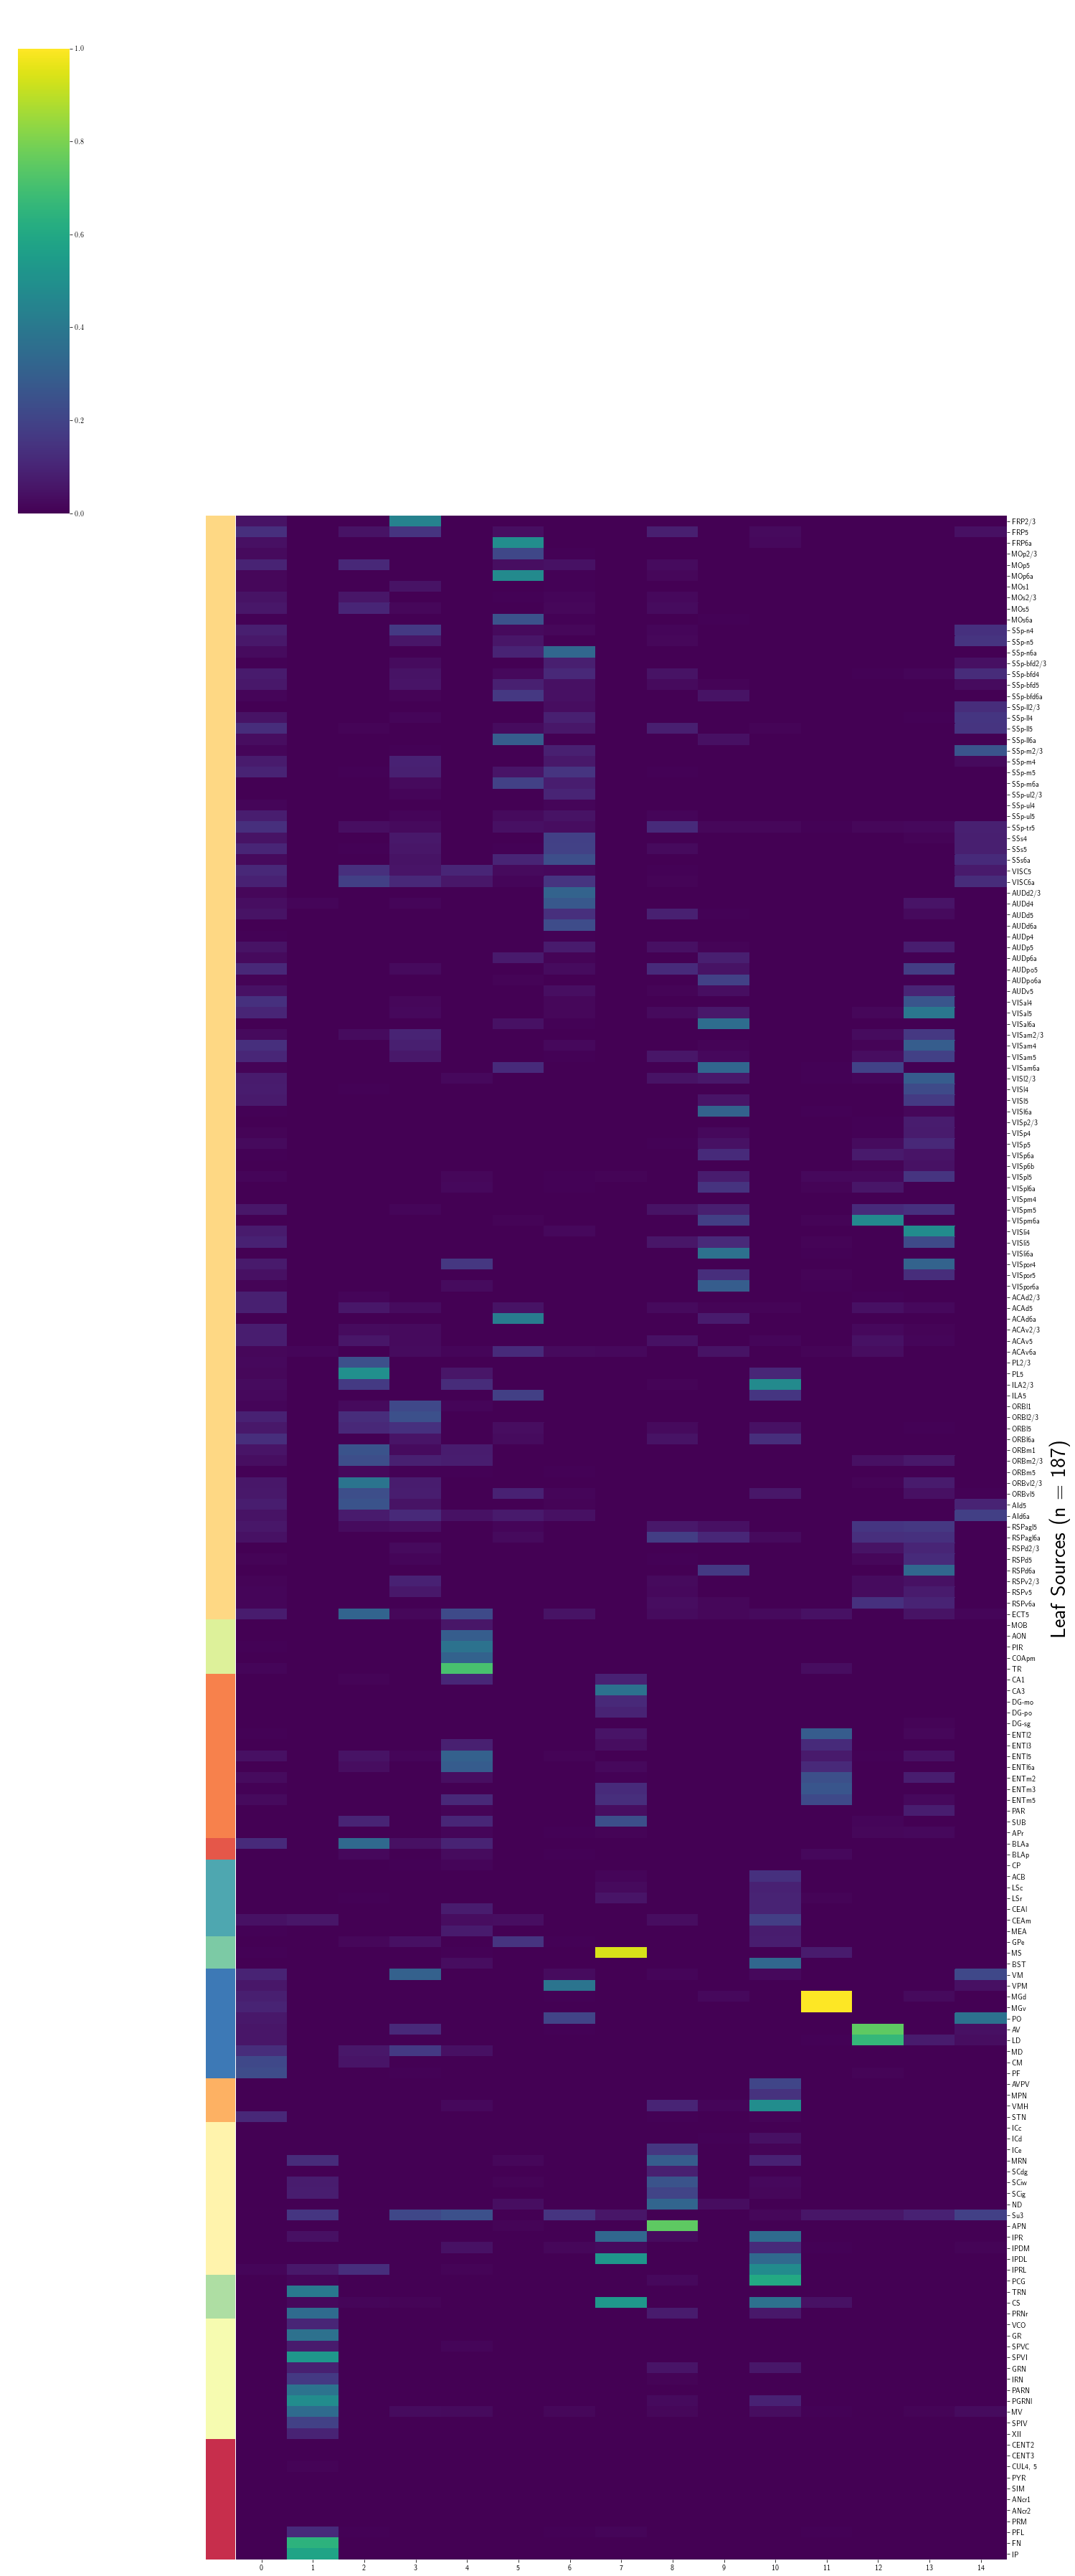

In [130]:
#fig, ax = plt.subplots()
#toplot = np.log(W)
#toplot[np.where(toplot< -9)] = -9
g= sns.clustermap(W, vmin = 0, figsize = (20,50),vmax=  1., cmap = 'viridis', col_cluster=False, row_cluster=False, row_colors=crow[ids])
#g.ax_heatmap.set_xticks([])
#g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels(wt_conn_sub.index, fontsize = 10)
#g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_ylabel('Leaf Sources (n = 187)', fontsize = 30)
# g.ax_heatmap.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 40)
# #g.ax_heatmap.set_ylabel('Leaf Sources (n = 564)', fontsize = 30)
# #g.set_title('Source-target distances', fontsize = 40)
# ax = gcf().add_axes((0.6,1.,0.,0.))
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# for label in np.asarray(major_structures)[reo]:
#     ax.bar(0, 0, color=ccol_dict[label], label=label, linewidth=0.)
# l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.14, .8), bbox_transform=gcf().transFigure, fontsize = 25,title_fontsize=40)    

# ax = gcf().add_axes((0.6,1.,0.,0.))
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# for label in np.asarray(major_structures)[reo]:
#     ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
# l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.14, .8), bbox_transform=gcf().transFigure, fontsize = 25,title_fontsize=40)    

# g.ax_cbar.set_xlabel(r"$\log (\mathcal C)$", rotation=0, fontsize = 20)
# g.ax_cbar.set_position([1.0,0.4,.1,.1])
# #g.ax_cbar.axhline(15, color = 'red', linewidth = 5)
# g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 50, color  = 'fuchsia')
# g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 50, color  = 'purple')
# g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
# g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
# g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
# g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)

#component 8 is the ntsr1 component
g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/W_wt', pad_inches = 0)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


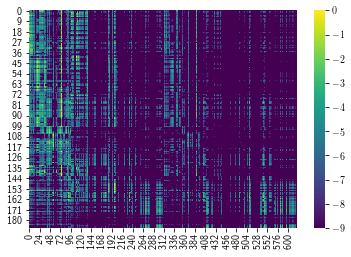

In [90]:
sns.heatmap(np.log(W @ H), vmin = -9, vmax= 0, cmap = 'viridis')

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


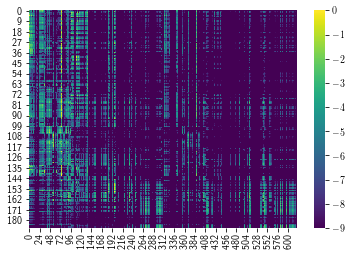

In [91]:
sns.heatmap(np.log(W[:,:14] @ H[:14]), vmin = -9, vmax= 0, cmap = 'viridis')

In [94]:
inds = np.asarray([0,1,2,3,4,5,6,7,8,10,11,12,13])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


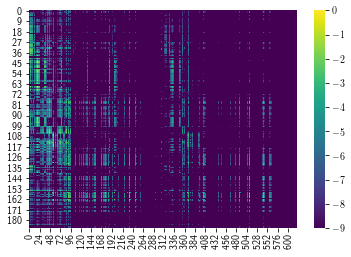

In [98]:
sns.heatmap(np.log(W[:,10:] @ H[10:]), vmin = -9, vmax= 0, cmap = 'viridis')

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


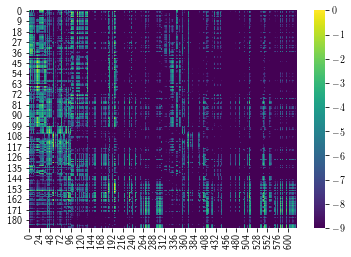

In [99]:
sns.heatmap(np.log(W[:,5:] @ H[5:]), vmin = -9, vmax= 0, cmap = 'viridis')

In [51]:
# fig, ax = plt.subplots(figsize = (15,15))
# toplot = np.log(archetypes)
# toplot[np.where(toplot< -9)] = -9
# sns.heatmap(toplot, vmin = -9, vmax=  0, ax = ax, cmap = 'viridis')
# #component 8 is the ntsr1 component

In [317]:
kmeans.inertia_

45.03087299470874

In [52]:
import sklearn.metrics as metrics

In [311]:
cluster_reps = np.zeros((nreps_cluster,combined.shape[0]))
for c in range(nreps_cluster):
    kmeans  = cluster.KMeans(n_clusters=nclust)
    kmeans.fit(combined)
    cluster_reps[c] = kmeans.labels_
    #clusts = kmeans.labels_[kmeans.labels_.argsort()]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [340]:
nmf.

'frobenius'

In [335]:
cluster_reps[i]

array([ 7.,  3.,  5.,  8.,  6., 10.,  9., 11.,  0.,  1., 13.,  2.,  6.,
        0.,  4.,  2., 14.,  0., 11.,  7.,  9.,  1., 12.,  4., 13., 10.,
        8.,  4.,  5.,  3.,  4., 10.,  1.,  0., 12.,  6.,  9.,  5.,  2.,
        9.,  8., 13.,  7.,  3., 11.,  0.,  8.,  5.,  6., 11.,  2.,  4.,
        6.,  3.,  9., 13., 10.,  1.,  7., 14.,  0., 14.,  3.,  4.,  2.,
       13.,  8.,  5.,  1.,  6.,  9., 10.,  9.,  6., 11.,  6.,  2., 10.,
        0.,  9.,  8.,  0.,  1., 11.,  6., 11.,  6., 13.,  4.,  5.,  4.,
        1.,  0.,  3.,  9.,  2., 14., 11.,  5.,  9.,  6.,  8., 11., 13.,
        7.,  7.,  2.,  0.,  9.,  9.,  4., 12.,  1., 14., 11.,  3.,  6.,
       13.,  8.,  5.,  6.,  1.,  8., 12., 13.,  2.,  0.,  0., 11.,  5.,
       10., 14.,  4.,  6.,  9.,  6.,  4.,  9.,  7.,  3., 11., 10., 13.,
       14.,  5.,  0.,  9.,  8.,  2.,  1.])

In [336]:
drv.information_variation(np.asarray(cluster_reps[i], dtype = object), np.asarray(cluster_reps[j], dtype = object))

TypeError: check_is_fitted() missing 1 required positional argument: 'attributes'

In [337]:
help(sklearn)

Help on package sklearn:

NAME
    sklearn

DESCRIPTION
    Machine learning module for Python
    
    sklearn is a Python module integrating classical machine
    learning algorithms in the tightly-knit world of scientific Python
    packages (numpy, scipy, matplotlib).
    
    It aims to provide simple and efficient solutions to learning problems
    that are accessible to everybody and reusable in various contexts:
    machine-learning as a versatile tool for science and engineering.
    
    See http://scikit-learn.org for complete documentation.

PACKAGE CONTENTS
    __check_build (package)
    _build_utils (package)
    _config
    _distributor_init
    _isotonic
    base
    calibration
    cluster (package)
    compose (package)
    conftest
    covariance (package)
    cross_decomposition (package)
    datasets (package)
    decomposition (package)
    discriminant_analysis
    dummy
    ensemble (package)
    exceptions
    experimental (package)
    externals (package)
   

In [327]:
variation_of_information(cluster_reps[i], cluster_reps[j])

TypeError: object of type 'numpy.float64' has no len()

In [313]:
np.nanmean(rands)

0.9095079426155825

In [330]:
# from math import log

# def variation_of_information(X, Y):
#     n = float(sum([len(x) for x in X]))
#     sigma = 0.0
#     for x in X:
#         p = len(x) / n
#         for y in Y:
#             q = len(y) / n
#             r = len(set(x) & set(y)) / n
#             if r > 0.0:
#                 sigma += r * (log(r / p, 2) + log(r / q, 2))
#     return(abs(sigma))

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


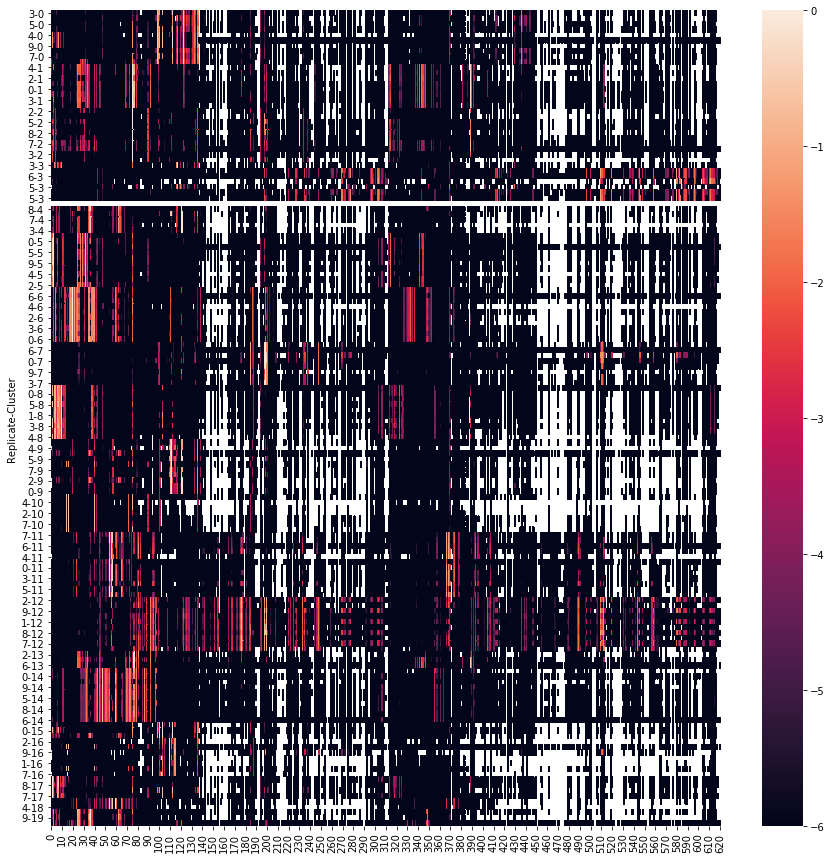

In [214]:

#multiind cre_inds, layers, summary
rep_labels = np.asarray(np.repeat(list(range(10)),15)[kmeans.labels_.argsort()], dtype = str)
clust_labels = np.asarray(clusts, dtype = str)
row_multi_ind = np.vstack([rep_labels,clust_labels])
row_multi_ind = np.asarray(row_multi_ind, dtype = str)
row_multi_ind_tuples = list(zip(*row_multi_ind))
row_multi_ind_tuples = pd.MultiIndex.from_tuples(row_multi_ind_tuples, names=['Replicate', 'Cluster'])



rep_labels = row_multi_ind_tuples.get_level_values("Replicate")
#rep_labels = pd.Index(rep_labels, dtype = object)#pd.I(rep_labels, index=  np.asarray( list(range(150)) ,dtype = object))
rep_pal = sns.color_palette("cubehelix", n_colors = np.unique(rep_labels).shape[0])
rep_lut = dict(zip(map(str, np.unique(rep_labels)), rep_pal))
rep_colors = pd.Series(rep_labels, index=row_multi_ind_tuples).map(rep_lut)


#clust_labels = pd.DataFrame(clust_labels, index=  np.asarray( list(range(150)) ,dtype = object))
clust_labels = row_multi_ind_tuples.get_level_values("Cluster")
#clust_labels= pd.Index(clust_labels, dtype = object)
clust_pal = sns.color_palette("Paired", np.unique(clust_labels).shape[0]) #sns.cubehelix_palette(summary_labels.unique().size, light=.9, dark=0.1, reverse=False, start=0, rot=-1, hue = 1)#sns.cubehelix_palette(summary_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
clust_lut = dict(zip(map(str, np.unique(clust_labels)), clust_pal))
clust_colors = pd.Series(clust_labels, index=row_multi_ind_tuples).map(clust_lut)

arr = np.zeros((150,2), dtype = object)
arr[:,0] = rep_colors
arr[:,1] = clust_colors
combined_colors = pd.DataFrame(arr, index = clust_colors.index)

toplot = pd.DataFrame(np.log(combined[kmeans.labels_.argsort()]), index= combined_colors.index)

fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(toplot , vmin = -6, vmax= 0, ax = ax)

We adopt a stability-based method for determining the number of clusters of vectors returned by NMF.

We would like low-variance clusters selected in every replicate.

we have latent vectors
\begin{align*}
v_{1:l}
\end{align*}
and replicates
\begin{align*}
v_{1:l, 1:r}
\end{align*}
clusters should be size $r$.

In [164]:
combined.shape

(150, 621)

In [21]:
#help(NMF)
nmf = NMF(n_components=15, alpha=0., l1_ratio=1., solver='mu', init = 'random', max_iter=50000, beta_loss='kullback-leibler')
nmf.fit(data[ids])
tnmf_sk = nmf.transform(np.asarray(data[ids]))
itnmf_sk = nmf.inverse_transform(tnmf_sk)

to_plot = np.asarray(np.log(nmf.components_[:10]))
to_plot[np.where(to_plot < -6)] = -6

NameError: name 'ids' is not defined

In [93]:
output = np.log(itnmf_sk)
output[np.where(output < -6)] = -6

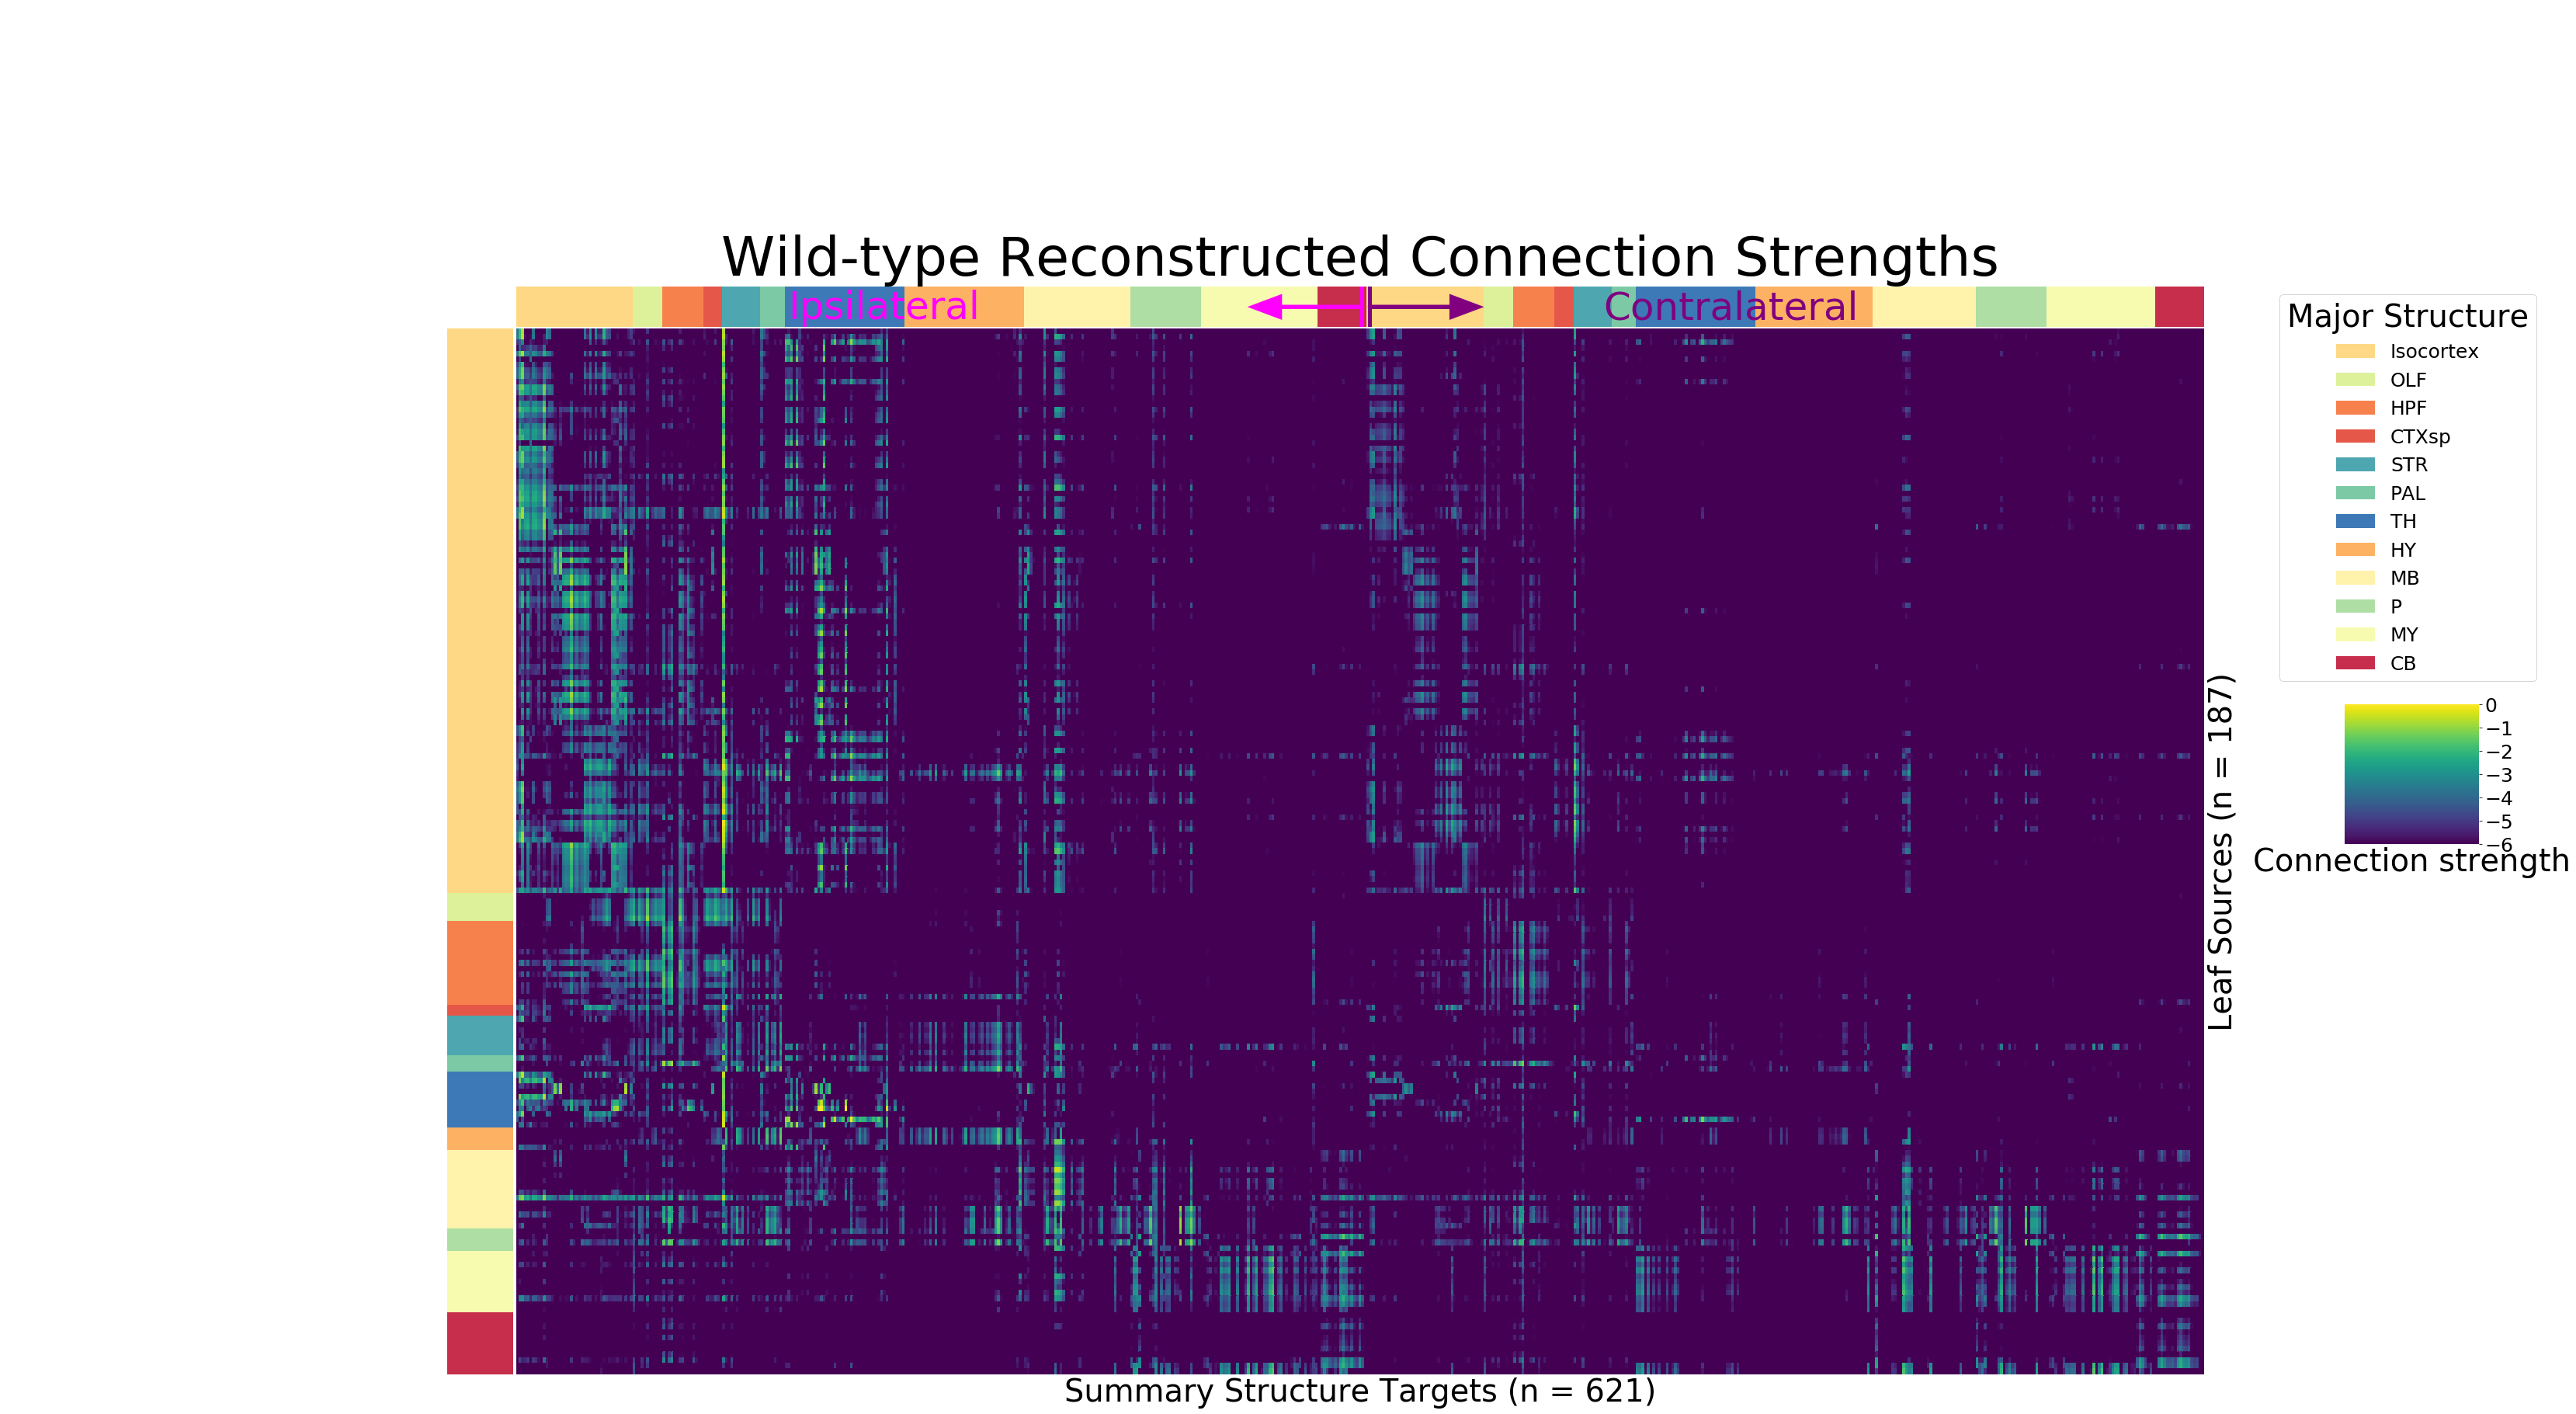

In [107]:
g= sns.clustermap(output, col_cluster = False, row_cluster = False, col_colors=ccol, 
                  row_colors = crow[ids], figsize = (40,25), cmap = 'viridis', vmin = -6, vmax = 0.)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 40)
g.ax_heatmap.set_ylabel('Leaf Sources (n = 187)', fontsize = 40)
ax = gcf().add_axes((0.6,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.14, .8), bbox_transform=gcf().transFigure, fontsize = 25,title_fontsize=40)    

g.ax_cbar.set_xlabel('Connection strength', rotation=0, fontsize = 40)
g.ax_cbar.set_yticklabels(g.ax_cbar.get_yticklabels(), fontsize=25)
g.ax_cbar.set_position([1.05,0.4,.06,.1])
g.ax_cbar.axhline(15, color = 'red', linewidth = 5)
g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 50, color  = 'fuchsia')
g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 50, color  = 'purple')
g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)
g.ax_col_colors.set_title('Wild-type Reconstructed Connection Strengths', fontsize = 70)

g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/wt_recon', pad_inches = 0)


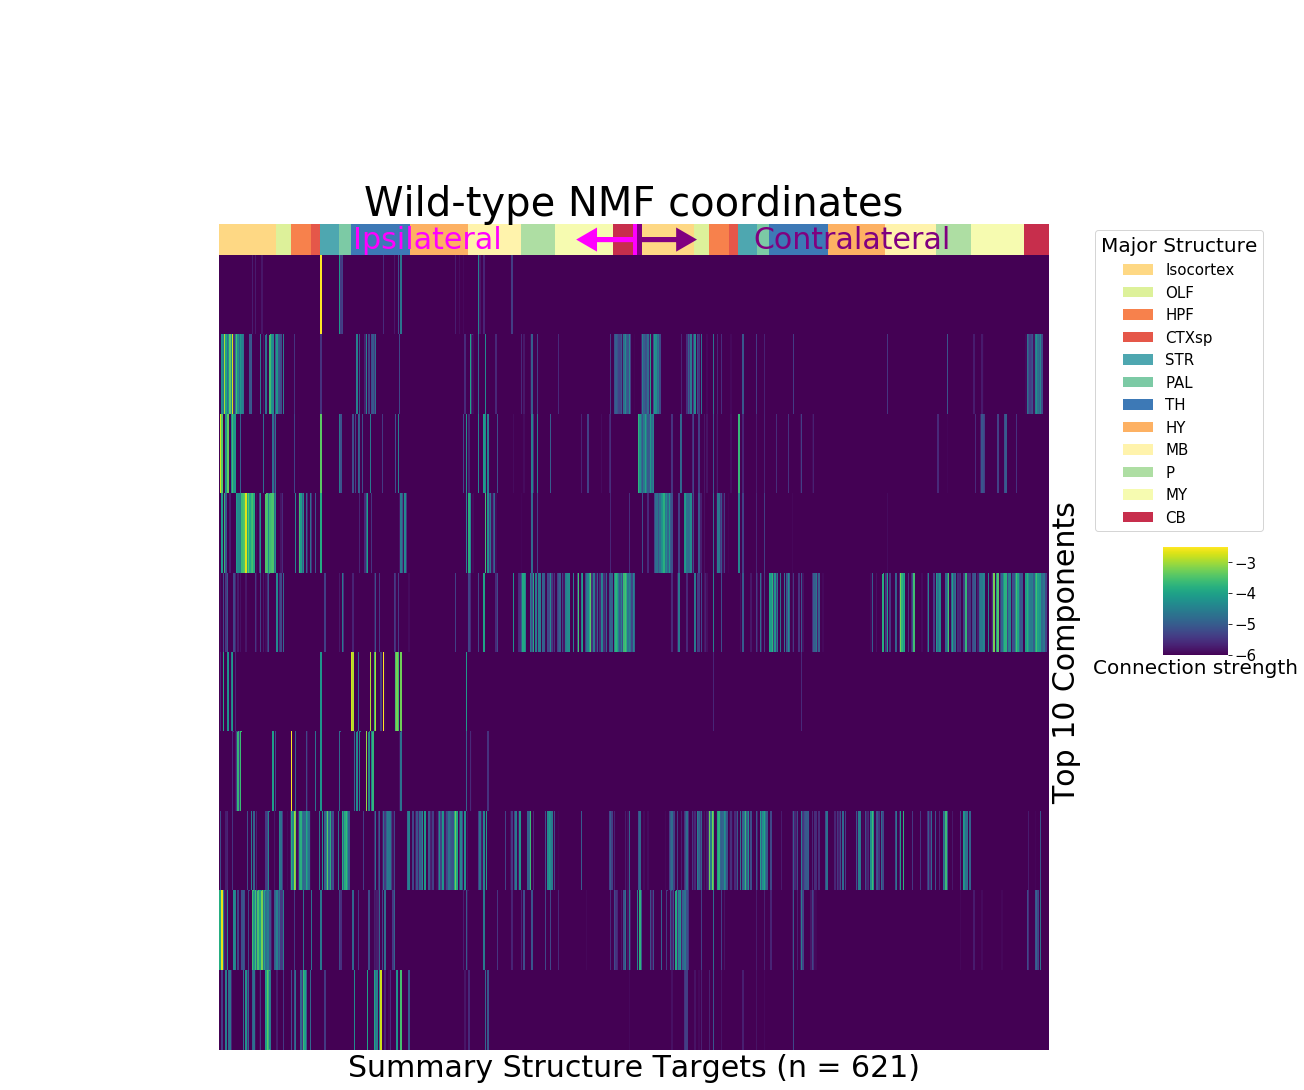

In [30]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(to_plot, vmin = -6, vmax = 1. , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15), cmap = 'viridis')

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Top 10 Components', fontsize = 30)
g.ax_heatmap.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 30, color  = 'fuchsia')
g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 30, color  = 'purple')
g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)

ax = gcf().add_axes((0.6,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.18, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Connection strength', rotation=0, fontsize = 20)
g.ax_cbar.set_yticklabels(g.ax_cbar.get_yticklabels(), fontsize=15)
g.ax_cbar.set_position([1.08,0.4,.06,.1])
g.ax_col_colors.set_title('Wild-type NMF coordinates', fontsize = 40)
# g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
#     pad_inches = 0)

plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/wt_nmf_alpha0', pad_inches = 0)


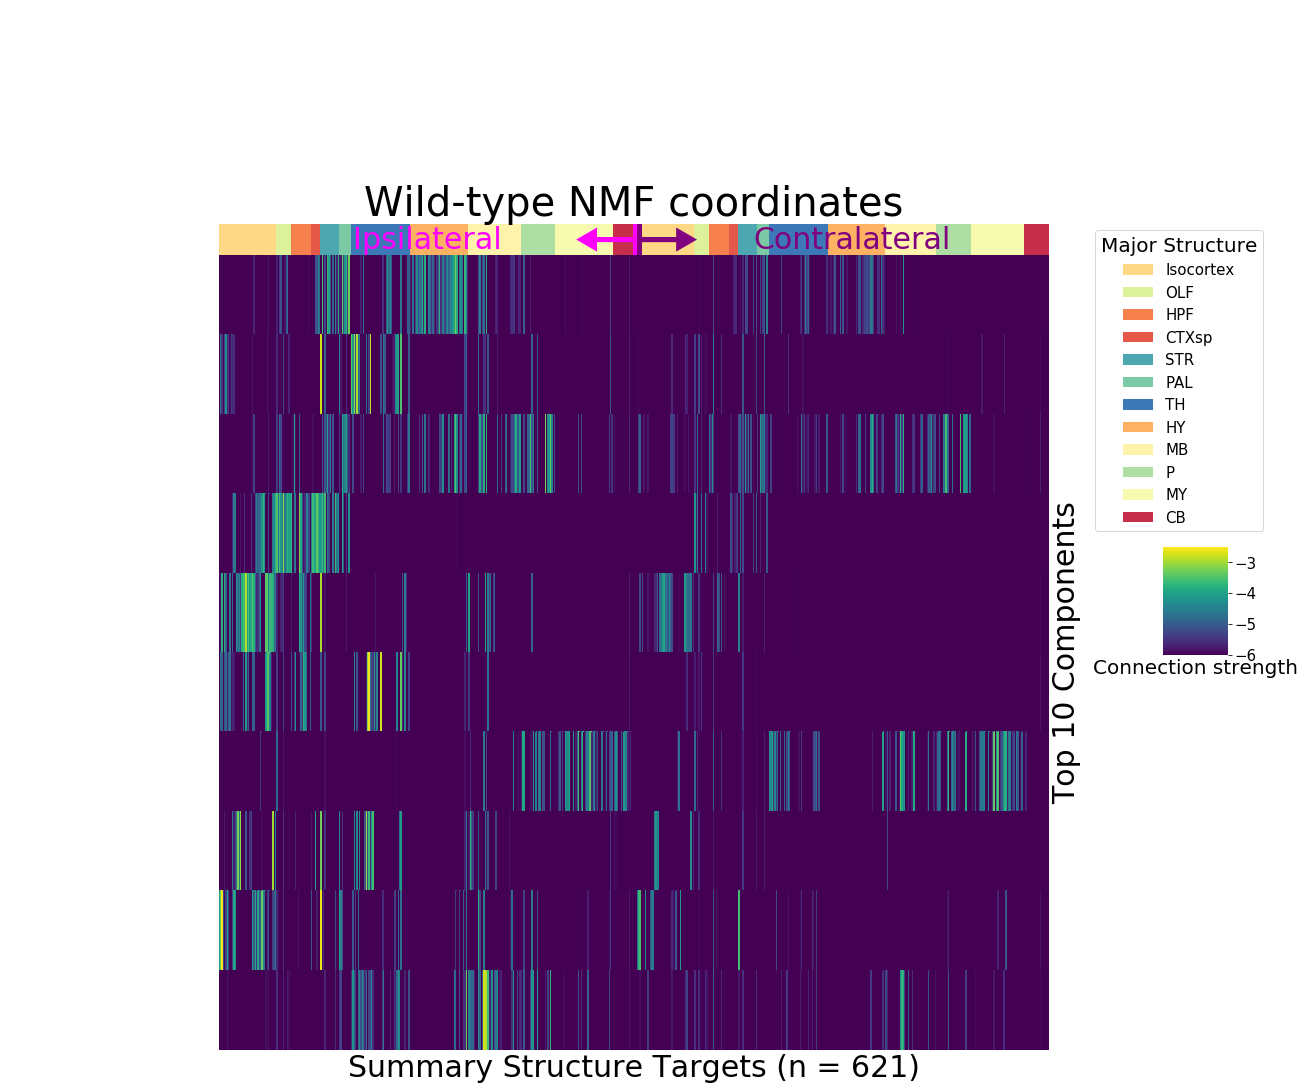

In [113]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(to_plot, vmin = -6, vmax = 1. , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15), cmap = 'viridis')

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Top 10 Components', fontsize = 30)
g.ax_heatmap.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 30, color  = 'fuchsia')
g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 30, color  = 'purple')
g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)

ax = gcf().add_axes((0.6,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.18, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Connection strength', rotation=0, fontsize = 20)
g.ax_cbar.set_yticklabels(g.ax_cbar.get_yticklabels(), fontsize=15)
g.ax_cbar.set_position([1.08,0.4,.06,.1])
g.ax_col_colors.set_title('Wild-type NMF coordinates', fontsize = 40)
# g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
#     pad_inches = 0)

g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/wt_nmf_alpha0', pad_inches = 0)


In [23]:
#help(NMF)
nmf = NMF(n_components=15, alpha=.02, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
nmf.fit(data[ids])
tnmf_sk = nmf.transform(np.asarray(data[ids]))
itnmf_sk = nmf.inverse_transform(tnmf_sk)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [158]:
ncomp = 15
nreps = 10
components = np.zeros((nreps,ncomp,621))
for r in range(nreps):
    print(r)
    nmf = NMF(n_components=ncomp, alpha=.02, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
    nmf.fit(data[ids])
    components[r] = nmf.components_

0


KeyError: '[  1   2   3   6   7   8  10  11  12  13  17  18  19  22  23  24  25  28\n  29  30  31  34  35  36  37  40  41  42  48  59  60  61  72  73  76  77\n  78  79  83  84  85  90  91  96 101 102 103 106 107 108 109 112 113 114\n 115 118 119 120 121 122 126 127 131 132 133 137 138 139 143 144 145 148\n 149 150 153 154 155 158 159 163 164 167 168 169 170 172 173 174 178 179\n 184 185 199 200 203 204 205 208 209 210 237 240 244 248 254 256 257 259\n 260 261 262 266 267 268 269 271 272 273 275 278 281 286 287 292 293 296\n 297 304 305 307 308 312 315 318 321 328 329 335 338 344 346 354 357 374\n 398 402 410 417 418 419 429 430 432 433 436 437 438 459 464 465 466 479\n 484 490 494 500 502 506 507 516 519 527 530 535 536 539 545 546 547 550\n 553 554 555 556 558 560 561] not in index'

In [31]:
import sys
!{sys.executable} -m pip install einops

  Using cached https://files.pythonhosted.org/packages/5d/a0/9935e030634bf60ecd572c775f64ace82ceddf2f504a5fd3902438f07090/einops-0.3.0-py2.py3-none-any.whl


In [338]:
import sys
!{sys.executable} -m pip install sklearn --upgrade

  Using cached https://files.pythonhosted.org/packages/1e/7a/dbb3be0ce9bd5c8b7e3d87328e79063f8b263b2b1bfa4774cb1147bfcd3f/sklearn-0.0.tar.gz
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=80586003e26682bc94969a0e50a8f1ebedb3ef8c0486b56785df5f25faf5af9a
  Stored in directory: /Users/samsonkoelle/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [339]:
help(sklearn)

Help on package sklearn:

NAME
    sklearn

DESCRIPTION
    Machine learning module for Python
    
    sklearn is a Python module integrating classical machine
    learning algorithms in the tightly-knit world of scientific Python
    packages (numpy, scipy, matplotlib).
    
    It aims to provide simple and efficient solutions to learning problems
    that are accessible to everybody and reusable in various contexts:
    machine-learning as a versatile tool for science and engineering.
    
    See http://scikit-learn.org for complete documentation.

PACKAGE CONTENTS
    __check_build (package)
    _build_utils (package)
    _config
    _distributor_init
    _isotonic
    base
    calibration
    cluster (package)
    compose (package)
    conftest
    covariance (package)
    cross_decomposition (package)
    datasets (package)
    decomposition (package)
    discriminant_analysis
    dummy
    ensemble (package)
    exceptions
    experimental (package)
    externals (package)
   

In [331]:
import sys
!{sys.executable} -m pip install pyitlib

  Created wheel for pyitlib: filename=pyitlib-0.2.2-cp37-none-any.whl size=28502 sha256=3b7f93c7131e1ce843875f396ea9322639bf0437edce2c39c5d3f59f75fcecab
  Stored in directory: /Users/samsonkoelle/Library/Caches/pip/wheels/1c/f8/41/f4b4e777dd6ea714f2c4900367fb479e9fca0eb000c46e73f3
Successfully built pyitlib


In [332]:
import pyitlib

In [155]:
ncomp = 10

In [193]:
pyitlib.var

In [333]:
from pyitlib import discrete_random_variable as drv

In [167]:
from scipy.cluster import vq

In [180]:
# for i in range(combined.shape[0]):
#     for j in range(combined.shape[1]):
#         combined[i,j] = float(combined[i][j])

In [182]:
combined = np.asarray(combined, dtype = float)

In [186]:
#sns.heatmap(combined)

In [192]:
vq.kmeans(np.zeros((2,2)), k_or_guess = None)

ValueError: object arrays are not supported

In [189]:
vq.kmeans(combined[:2][:,:2], k_or_guess = None,iter = 10)

ValueError: object arrays are not supported

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


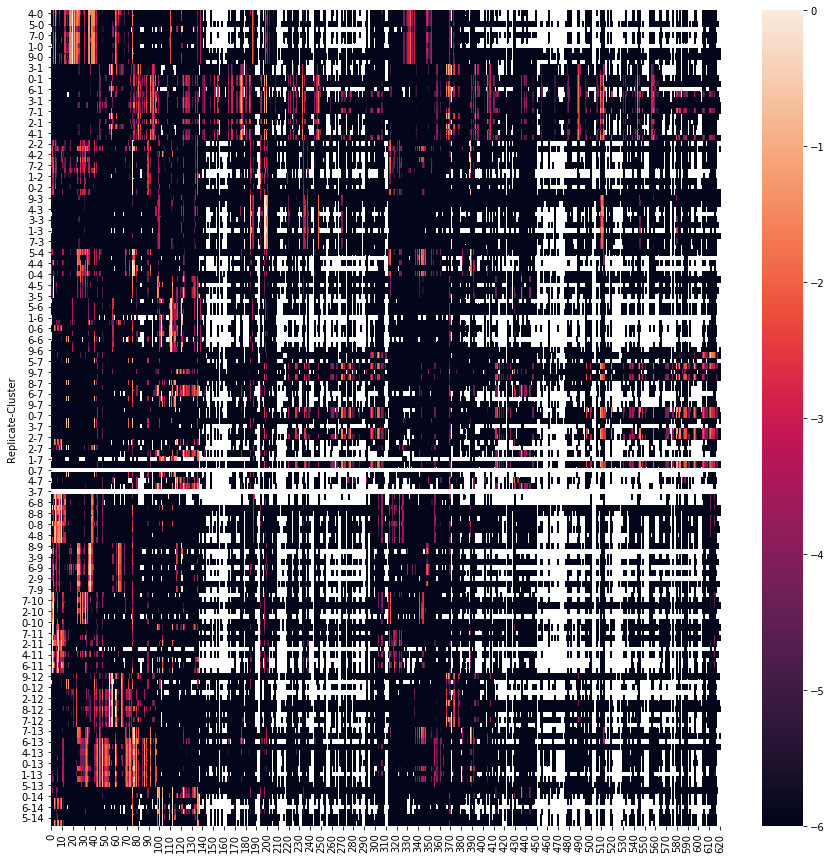

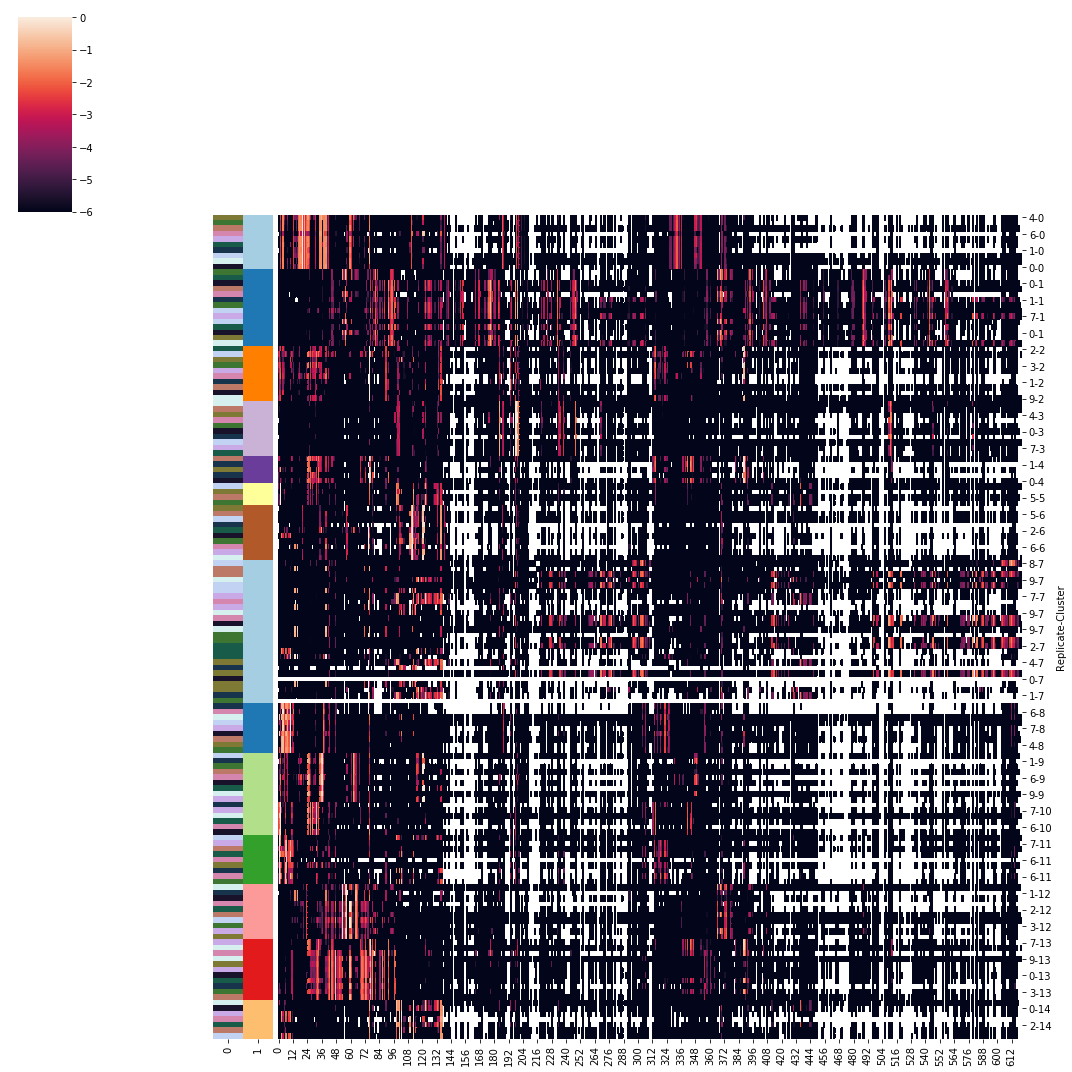

In [221]:
g = sns.clustermap(toplot , vmin = -6, vmax= 0,
    row_cluster=False, col_cluster=False, figsize = (15,15),
    row_colors= combined_colors )


In [211]:
tp

,,0,1,2,3,4,5,6,7,8,9,...,611,612,613,614,615,616,617,618,619,620
Replicate,Cluster,,,,,,,,,,,,,,,,,,,,,
0,0,-88.930443,-20.728309,-17.328851,-63.623837,-33.325635,-51.130341,-8.416608,-123.706030,-173.711261,-207.529858,...,-108.384923,-58.766992,-169.563884,-367.661508,-19.243925,-468.152511,-inf,-inf,-inf,-inf
1,0,-168.719997,-4.324584,-31.144181,-195.341351,-81.791282,-87.178112,-4.509747,-231.190219,-303.576247,-406.975324,...,-143.216436,-52.480156,-262.354202,-665.807682,-5.219322,-inf,-inf,-inf,-inf,-inf
4,0,-6.528118,-24.840572,-7.255305,-111.896608,-28.071020,-76.109261,-24.511165,-200.186381,-161.172985,-278.682593,...,-190.157257,-161.246559,-254.773101,-447.939189,-100.740549,-595.678560,-inf,-inf,-inf,-inf
9,0,-73.469515,-11.999032,-21.833464,-100.499564,-39.887913,-31.435114,-5.647750,-80.297453,-111.123559,-151.936728,...,-58.614718,-23.587127,-92.090171,-229.733533,-7.292772,-292.606323,-516.572224,-469.584455,-603.115897,-627.045323
5,0,-136.926942,-74.555112,-32.373532,-184.342889,-84.627389,-136.466336,-104.765874,-175.752810,-195.010586,-283.564116,...,-262.412809,-204.189638,-267.424973,-397.556933,-169.675117,-514.481074,-inf,-inf,-inf,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,14,-540.601558,-113.898231,-5.201541,-268.211545,-7.954369,-3.329505,-261.027695,-4.047267,-1.804782,-4.365988,...,-6.248946,-4.815380,-20.809434,-92.641715,-5.787924,-167.820224,-inf,-inf,-inf,-inf
9,14,-449.445551,-138.487729,-83.423342,-334.455021,-92.926021,-206.506796,-143.594869,-232.741533,-172.741635,-324.579481,...,-494.689752,-461.841512,-362.520630,-422.694769,-301.760319,-608.644156,-inf,-inf,-inf,-inf
1,14,-inf,-503.418005,-267.119342,-inf,-315.816062,-629.084172,-425.316366,-734.206022,-541.318306,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf


In [212]:
tp = np.asarray(toplot)
tp[np.where(tp < -9)] = -9
tp[np.isinf(tp)] = -9

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


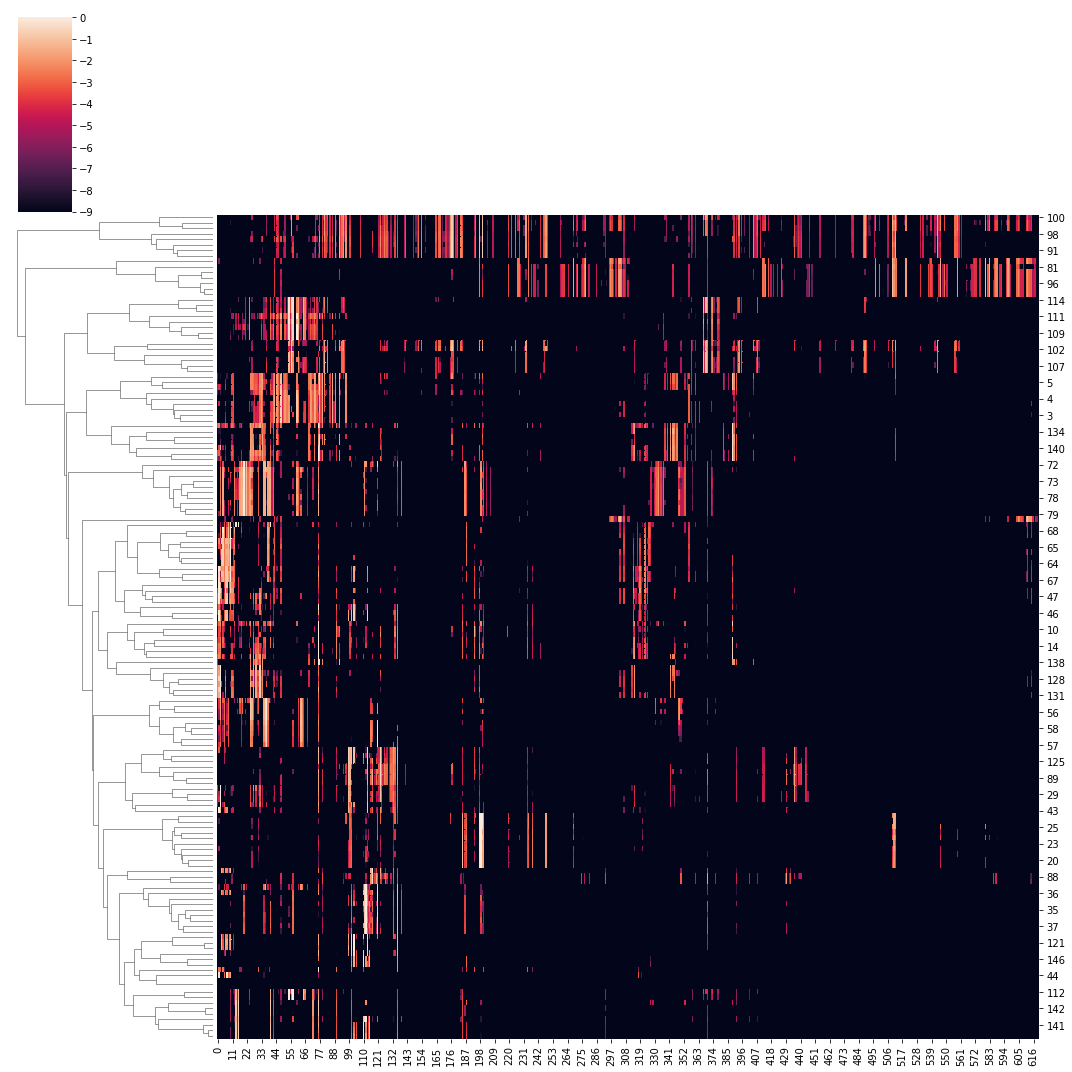

In [213]:
g = sns.clustermap(tp , vmin = -9, vmax= 0,
    row_cluster=True, col_cluster=False, figsize = (15,15))


In [27]:
nmf.components_[:10].shape

(10, 621)

In [24]:
to_plot = np.asarray(np.log(nmf.components_[:10]))
to_plot[np.where(to_plot < -6)] = -6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 1, 'Wild-type NMF coordinates')

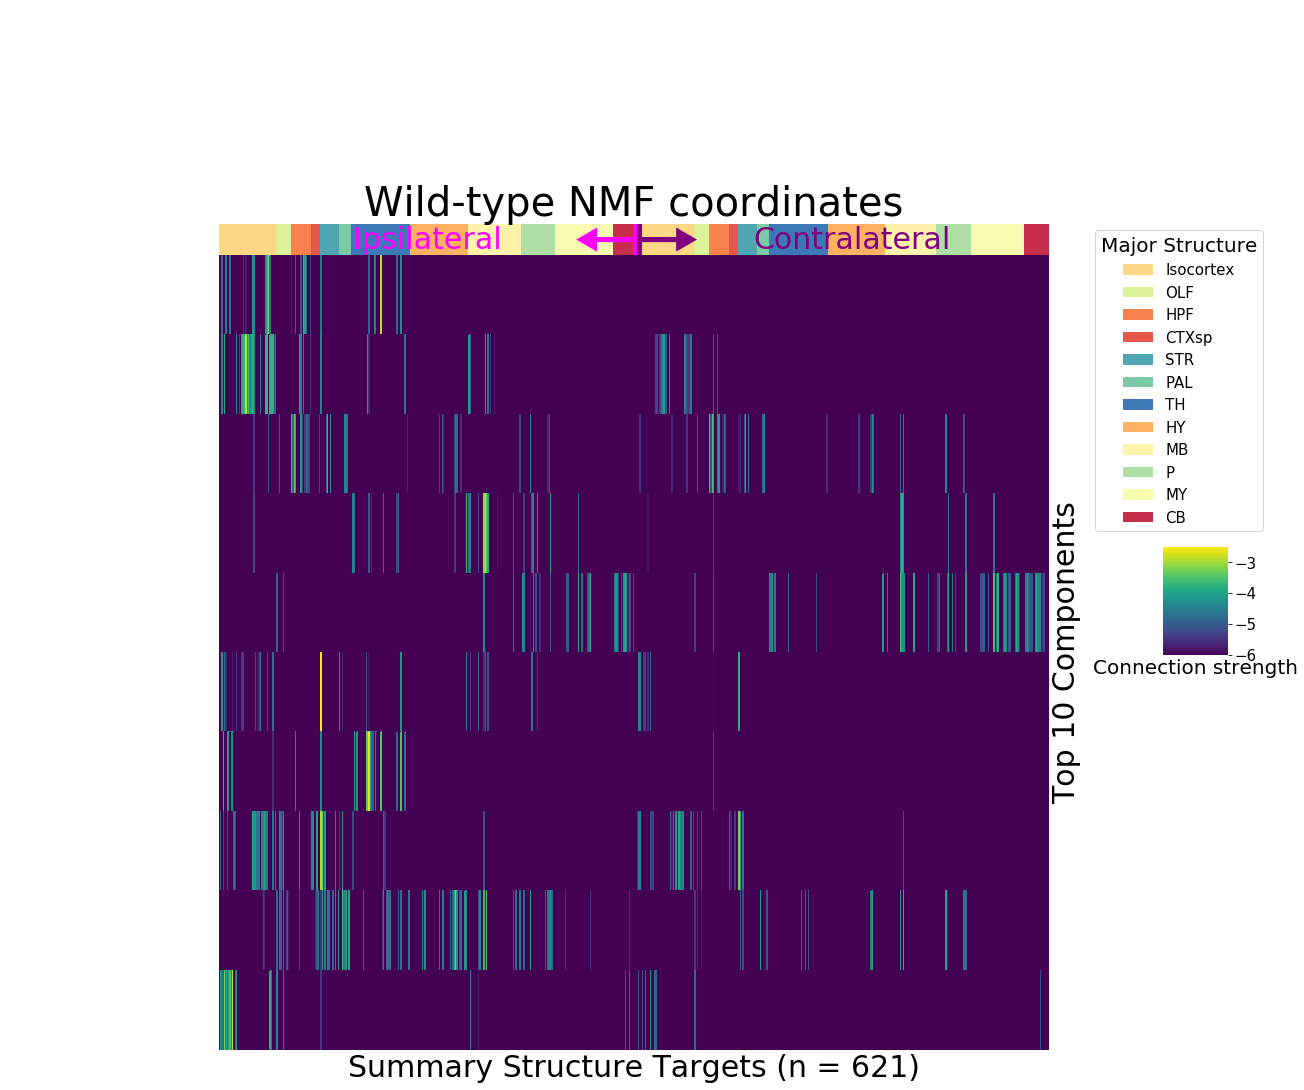

In [25]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(to_plot, vmin = -6, vmax = 1. , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15), cmap = 'viridis')

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Top 10 Components', fontsize = 30)
g.ax_heatmap.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 30, color  = 'fuchsia')
g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 30, color  = 'purple')
g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)

ax = gcf().add_axes((0.6,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.18, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Connection strength', rotation=0, fontsize = 20)
g.ax_cbar.set_yticklabels(g.ax_cbar.get_yticklabels(), fontsize=15)
g.ax_cbar.set_position([1.08,0.4,.06,.1])
g.ax_col_colors.set_title('Wild-type NMF coordinates', fontsize = 40)
# g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
#     pad_inches = 0)

#plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/wt_nmf', pad_inches = 0)


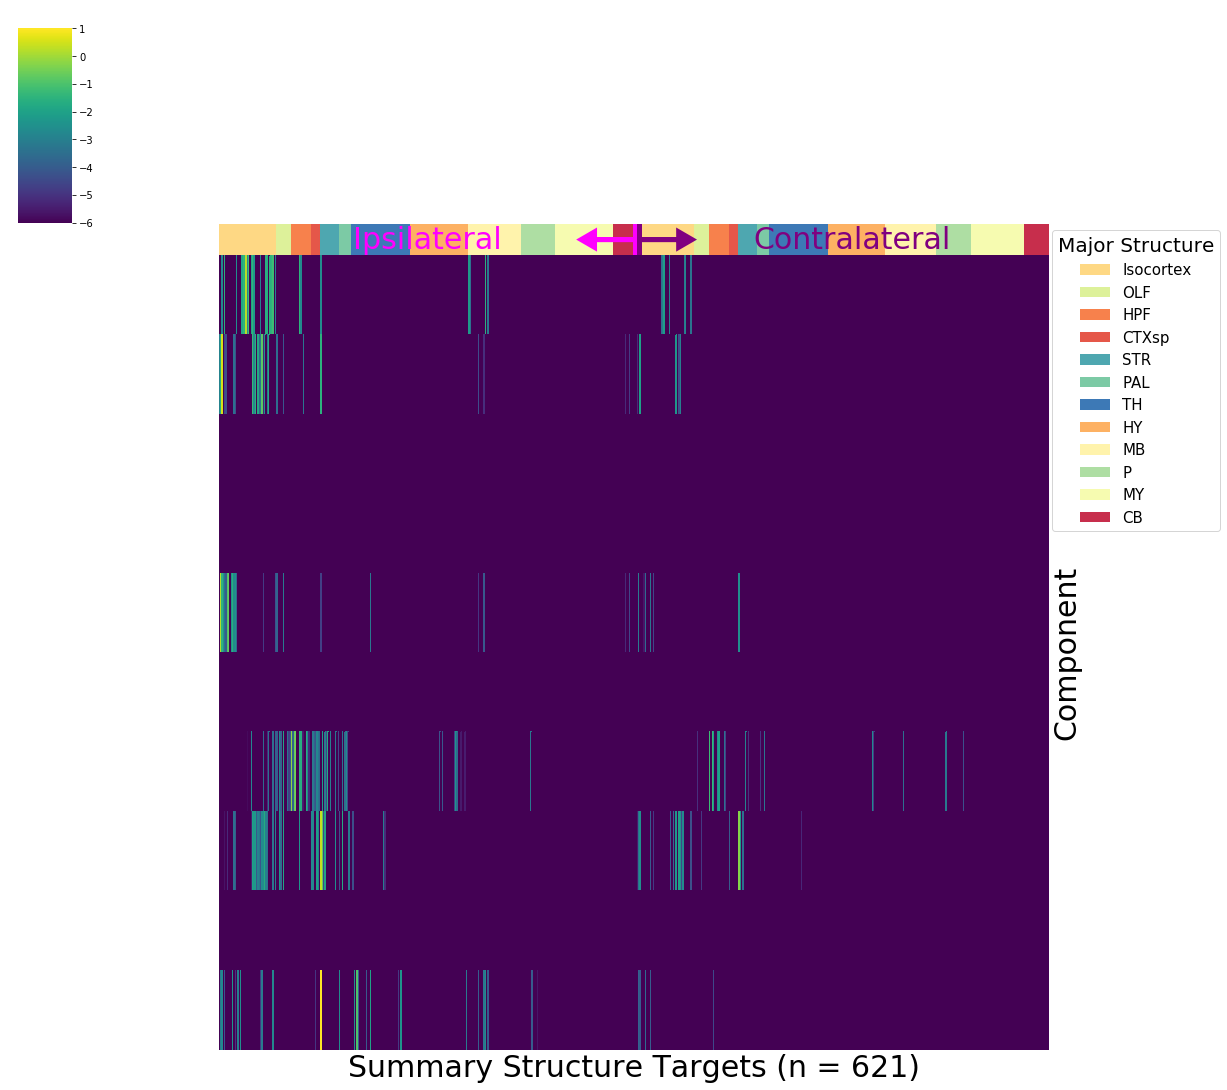

In [203]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(to_plot, vmin = -6, vmax = 1. , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15), cmap = 'viridis')

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 30, color  = 'fuchsia')
g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 30, color  = 'purple')
g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)

ax = gcf().add_axes((0.6,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.14, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    


# g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
#     pad_inches = 0)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


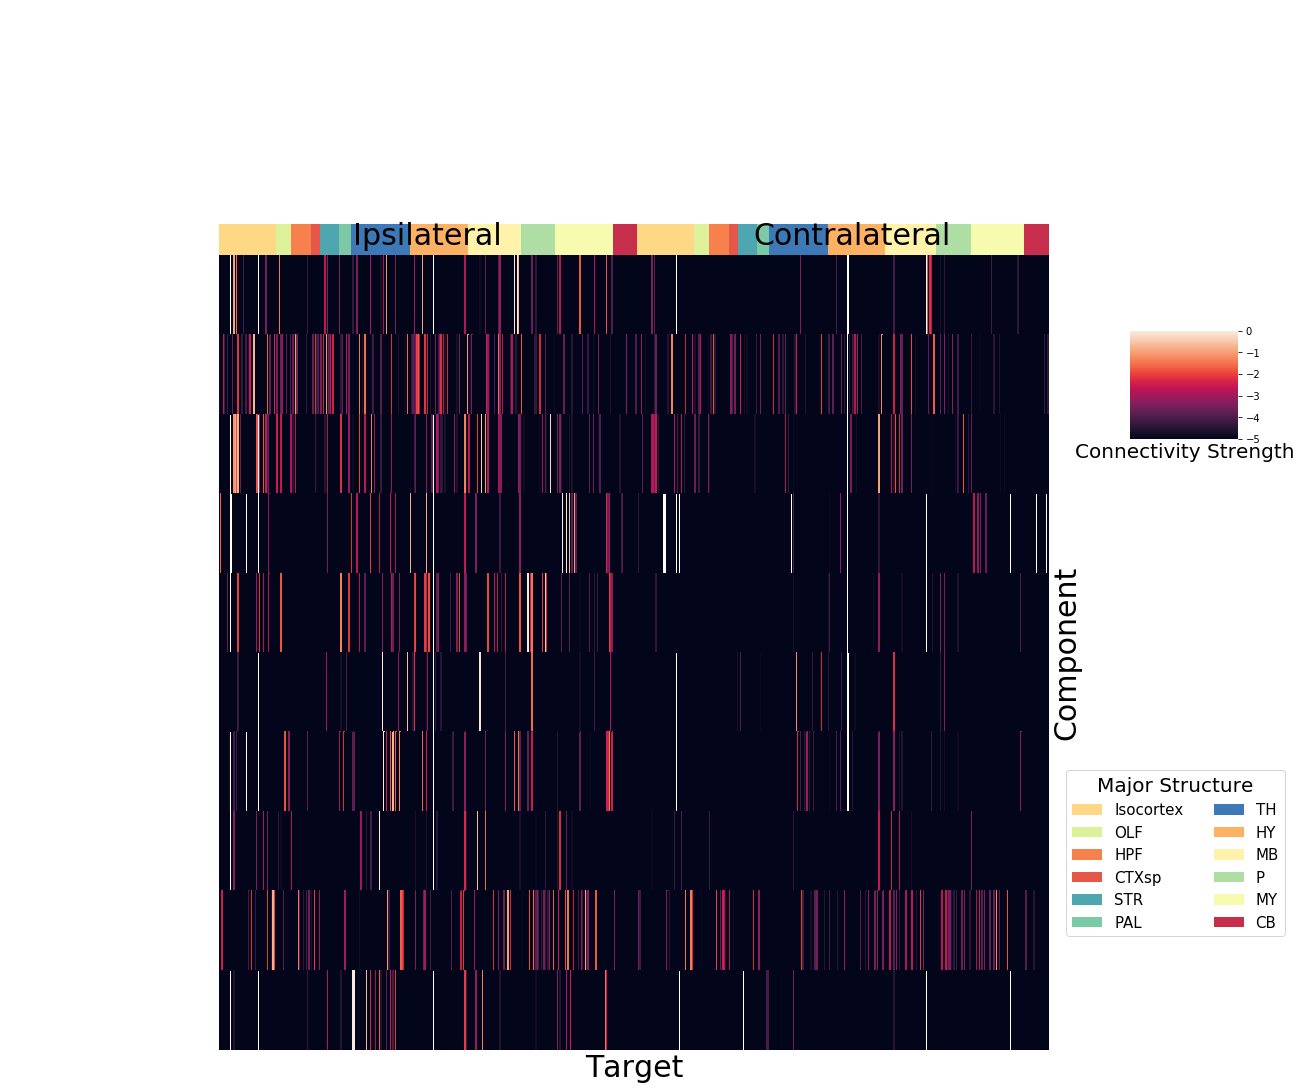

In [145]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(np.log(nmf.components_[:10]), vmin = -5, vmax = 0. , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15))

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.65, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.65, 'Contralateral', fontsize = 30)

ax = gcf().add_axes((0.74,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=2, bbox_to_anchor=(1.2, .3), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Connectivity Strength', rotation=0, fontsize = 20)
g.ax_cbar.set_position([1.05,0.6,.1,.1])

g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
    pad_inches = 0)

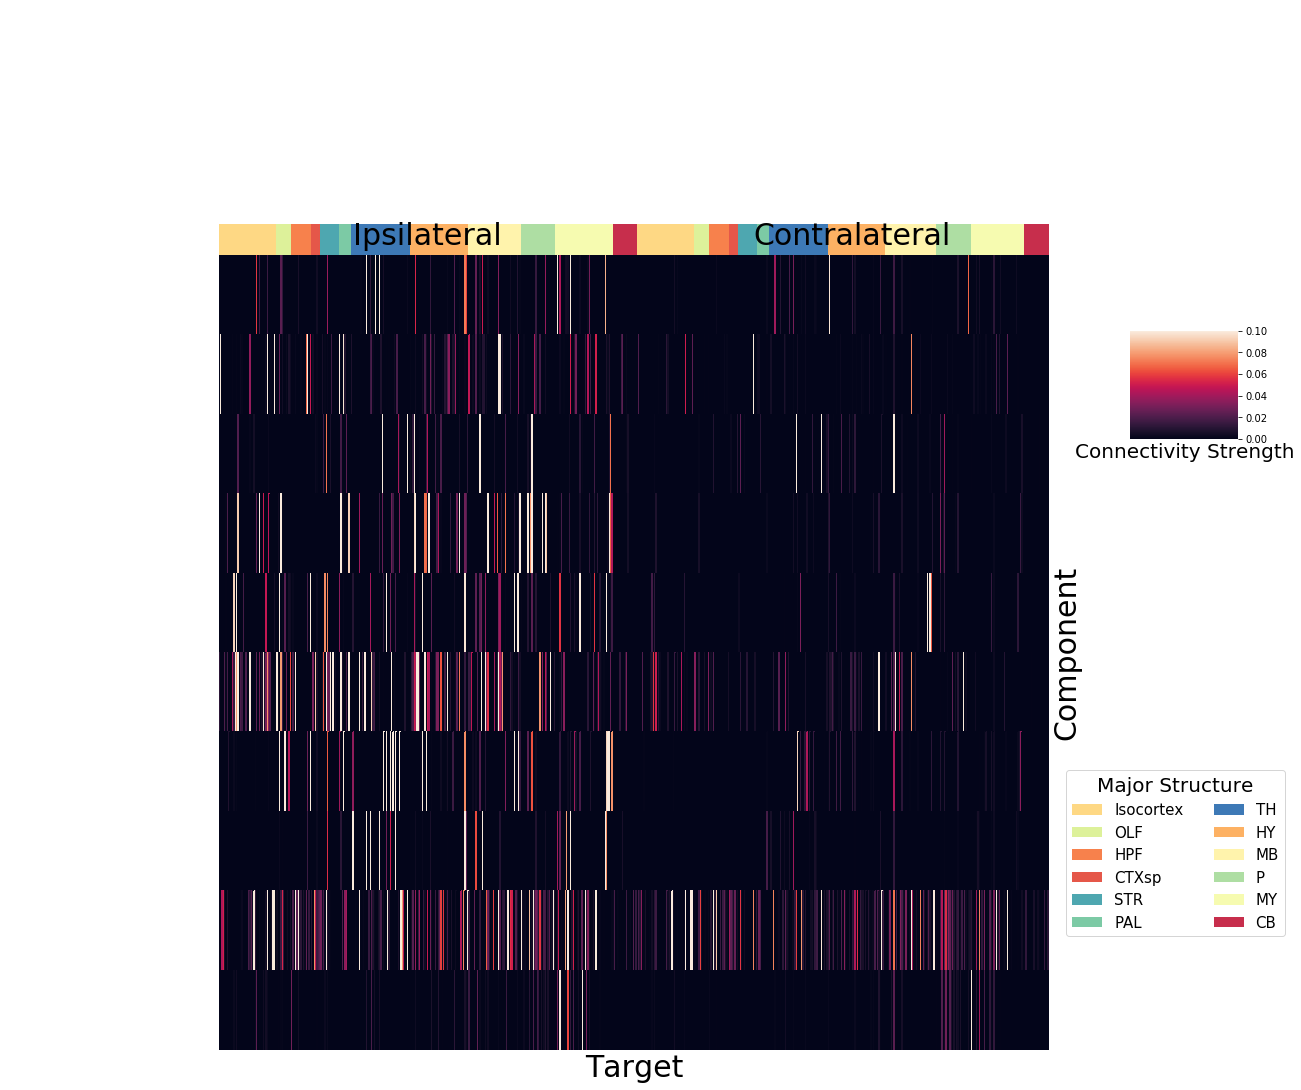

In [110]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(nmf.components_[:10], vmin = 0., vmax = 0.1 , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15))

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.65, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.65, 'Contralateral', fontsize = 30)

ax = gcf().add_axes((0.74,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=2, bbox_to_anchor=(1.2, .3), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Connectivity Strength', rotation=0, fontsize = 20)
g.ax_cbar.set_position([1.05,0.6,.1,.1])

g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
    pad_inches = 0)

In [48]:
cv_nmf_missing(data, n_components = 12 ,alpha=0.05, l1_ratio = 1.,p_holdout = .3)
        #train_err.append( tr)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(0.0011685605948125444, 0.0012725291942151421)

In [25]:
    n_components = 9 
    alpha=0.05
    l1_ratio = 1.
    p_holdout = .3
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [119]:
data_tr.shape

(564, 621)

In [36]:
for r in range(20):
    n_components = 9
    nmf = NMF(n_components=n_components, alpha=.01, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
    nmf.fit(data_tr)
    nmf.transform(data_tr)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

In [29]:
nmf.transform(data_tr)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ValueError: Array passed to NMF (input H) is full of zeros.

In [35]:
np.where(~np.isnan(data_tr))[0].shape,np.where(~np.isnan(data))[0].shape

((33676,), (111832,))

In [34]:
564 * 621

350244

In [27]:
nmf.transform(data_tr)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.63549039e-90, 0.00000000e+00, 0.00000000e+00, ...,
        6.37511954e-01, 7.83013650e-47, 0.00000000e+00],
       [2.71559682e-61, 1.64338244e-93, 0.00000000e+00, ...,
        6.34154853e-01, 5.67499085e-91, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [79]:
nmf.fit(data_tr)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


NMF(alpha=0.05, beta_loss='frobenius', init='random', l1_ratio=1.0,
    max_iter=500, n_components=12, random_state=None, shuffle=False,
    solver='mu', tol=0.0001, verbose=0)

In [98]:
nmf.transform(data_tr_bad)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.88569883e-13],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.83132024e-41],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [78]:
data_tr

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
        2.70699227e-14, 3.01528674e-07, 3.94723754e-06],
       [           nan,            nan,            nan, ...,
                   nan,            nan, 0.00000000e+00],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [81]:
data_tr_bad

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan, 9.80072458e-01,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
        5.20785533e-27,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [74]:
data_tr_bad = data_tr.copy()

In [34]:
n = 12
tr_results[r,n] , te_results[r,n] = cv_nmf_missing(data, n_components = n ,alpha=0.05, l1_ratio = 1.,p_holdout = .3)
        

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [32]:
cv_nmf_missing(data, n_components = n ,alpha=0.05, l1_ratio = 1.,p_holdout = .3)
        #train_err.append( tr)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(0.0009245273382793281, 0.0011881816642229455)

In [ ]:
fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = tr_results[:,1:], ax=  ax, color= 'blue')
sns.boxplot( data = te_results[:,1:], ax=  ax, color= 'red')
ax.set_xticklabels(list(range(1,25)))
ax.axvline(14, color='k', dashes=[2,2])
ax.text(20,.0004, 'Train',color = 'blue', fontsize = 40)
ax.text(20,.00038, 'Test',color = 'red', fontsize = 40)
ax.set_ylabel('Mean RSS', fontsize = 40)
ax.set_xlabel('# Components', fontsize = 40)
#fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/test_train.png')
#ax.legend()

In [252]:
mwt = pd.melt(wt_conn.reset_index(), id_vars=['index'])
#ax = sns.ecdfplot(mwt, x = 'value', hue = 'index')
#plt.xscale('symlog')

In [253]:
#mwt

In [230]:
mwt

,variable_0,variable_1,value
0,ipsi,TMv,NaN
1,ipsi,TMv,0.000218
2,ipsi,TMv,0.000731
3,ipsi,TMv,0.000275
4,ipsi,TMv,NaN
...,...,...,...
350239,contra,PN,NaN
350240,contra,PN,NaN
350241,contra,PN,NaN
350242,contra,PN,NaN


In [215]:
mwt

,variable_0,variable_1,value
0,ipsi,TMv,NaN
1,ipsi,TMv,0.000218
2,ipsi,TMv,0.000731
3,ipsi,TMv,0.000275
4,ipsi,TMv,NaN
...,...,...,...
350239,contra,PN,NaN
350240,contra,PN,NaN
350241,contra,PN,NaN
350242,contra,PN,NaN


In [211]:
pd.wide_to_long(mwt, i = 'variable_0', j = 'variable_1', stubnames=)

TypeError: wide_to_long() missing 1 required positional argument: 'stubnames'

In [200]:
cols = wt_conn.columns.values.tolist()
stacked = wt_conn[cols].stack().reset_index()

In [201]:
stacked

,level_0,level_1,contra,ipsi
0,ICc,AAA,0.000022,0.000015
1,ICc,ACAd,0.000399,0.000051
2,ICc,ACAv,0.001342,0.000395
3,ICc,ACB,0.000003,0.000021
4,ICc,ACVII,0.000000,0.000000
...,...,...,...,...
58526,APr,XII,0.000000,0.000000
58527,APr,Xi,0.000000,0.000000
58528,APr,ZI,0.000000,0.000000
58529,APr,x,0.000000,0.000000


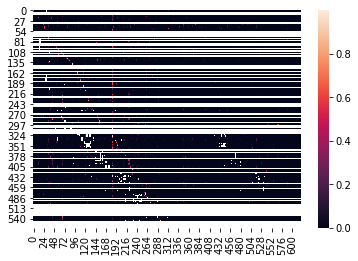

In [80]:
sns.heatmap(data)

AttributeError: 'Rectangle' object has no property 'ylim'

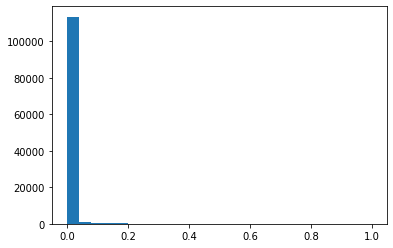

In [187]:
plt.hist(np.asarray(wt_conn).flatten(), bins = 25)

In [87]:
nmf = NMF(n_components=25, alpha=.0, l1_ratio=.5, solver='mu', init = 'random', max_iter=500)
nmf.fit(data)
tnmf_sk = nmf.transform(np.asarray(data))
itnmf_sk = nmf.inverse_transform(tnmf_sk)

# nmf = NMF(n_components=15, alpha=.01, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
# nmf.fit(data)
# tnmf_sk = nmf.transform(np.asarray(data))
# itnmf_sk = nmf.inverse_transform(tnmf_sk)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [94]:
#help(NMF)
nmf = NMF(n_components=15, alpha=.01, l1_ratio=.5, solver='mu', init = 'random', max_iter=500)
nmf.fit(data)
tnmf_sk = nmf.transform(np.asarray(data))
itnmf_sk = nmf.inverse_transform(tnmf_sk)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [103]:
nmf.components_[np.where(nmf.components_ < 1e-2)] = np.nan

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


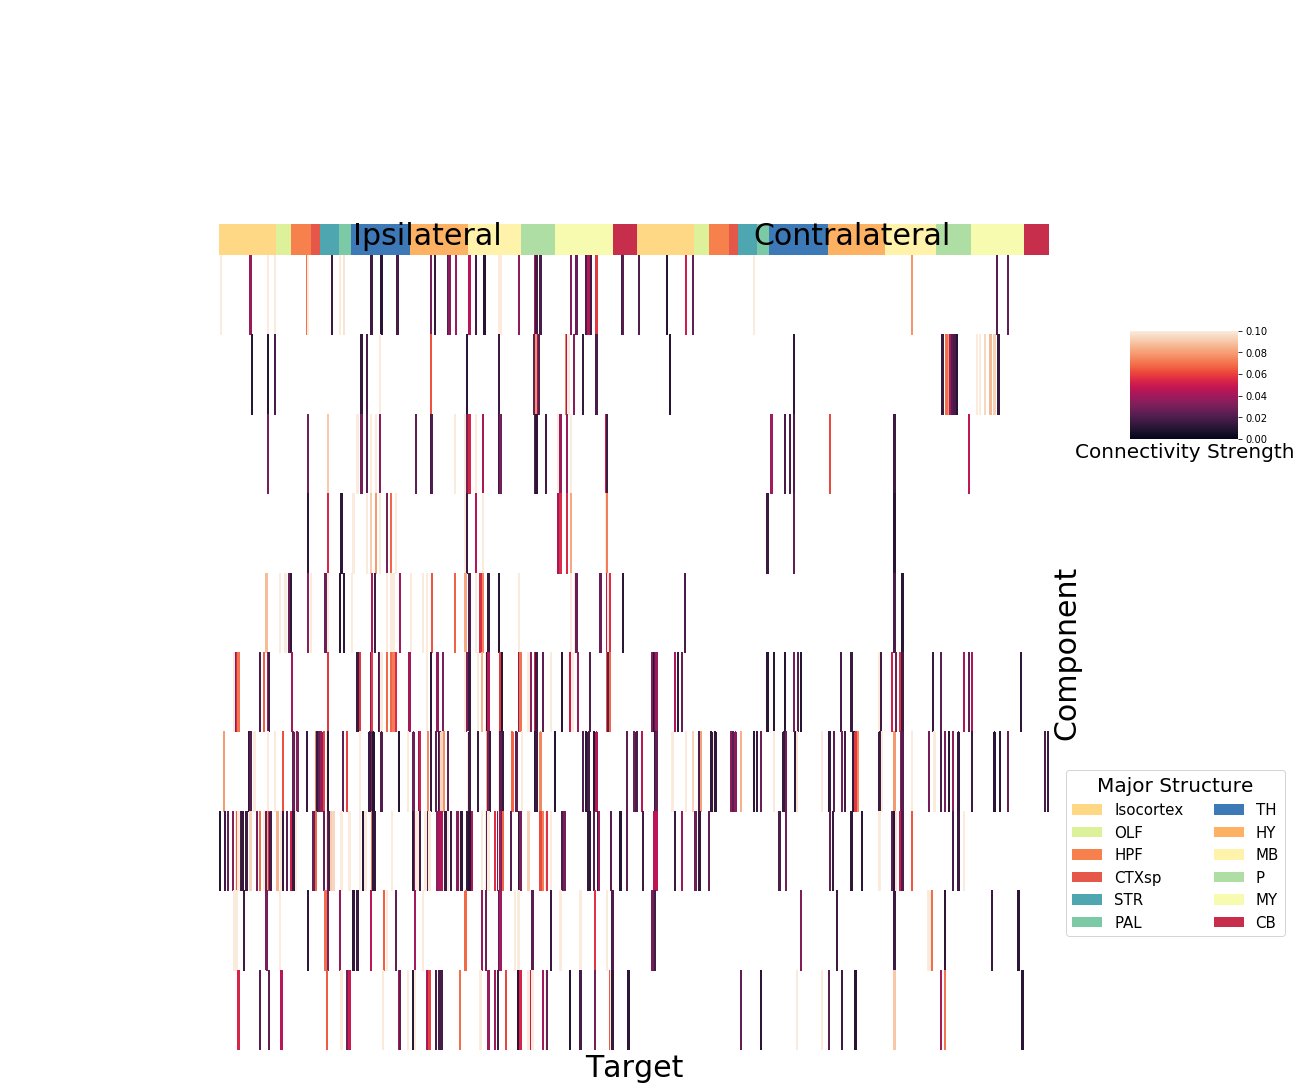

In [104]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(nmf.components_[:10], vmin = 0., vmax = 0.1 , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15))

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.65, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.65, 'Contralateral', fontsize = 30)

ax = gcf().add_axes((0.74,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=2, bbox_to_anchor=(1.2, .3), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Connectivity Strength', rotation=0, fontsize = 20)
g.ax_cbar.set_position([1.05,0.6,.1,.1])

g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
    pad_inches = 0)

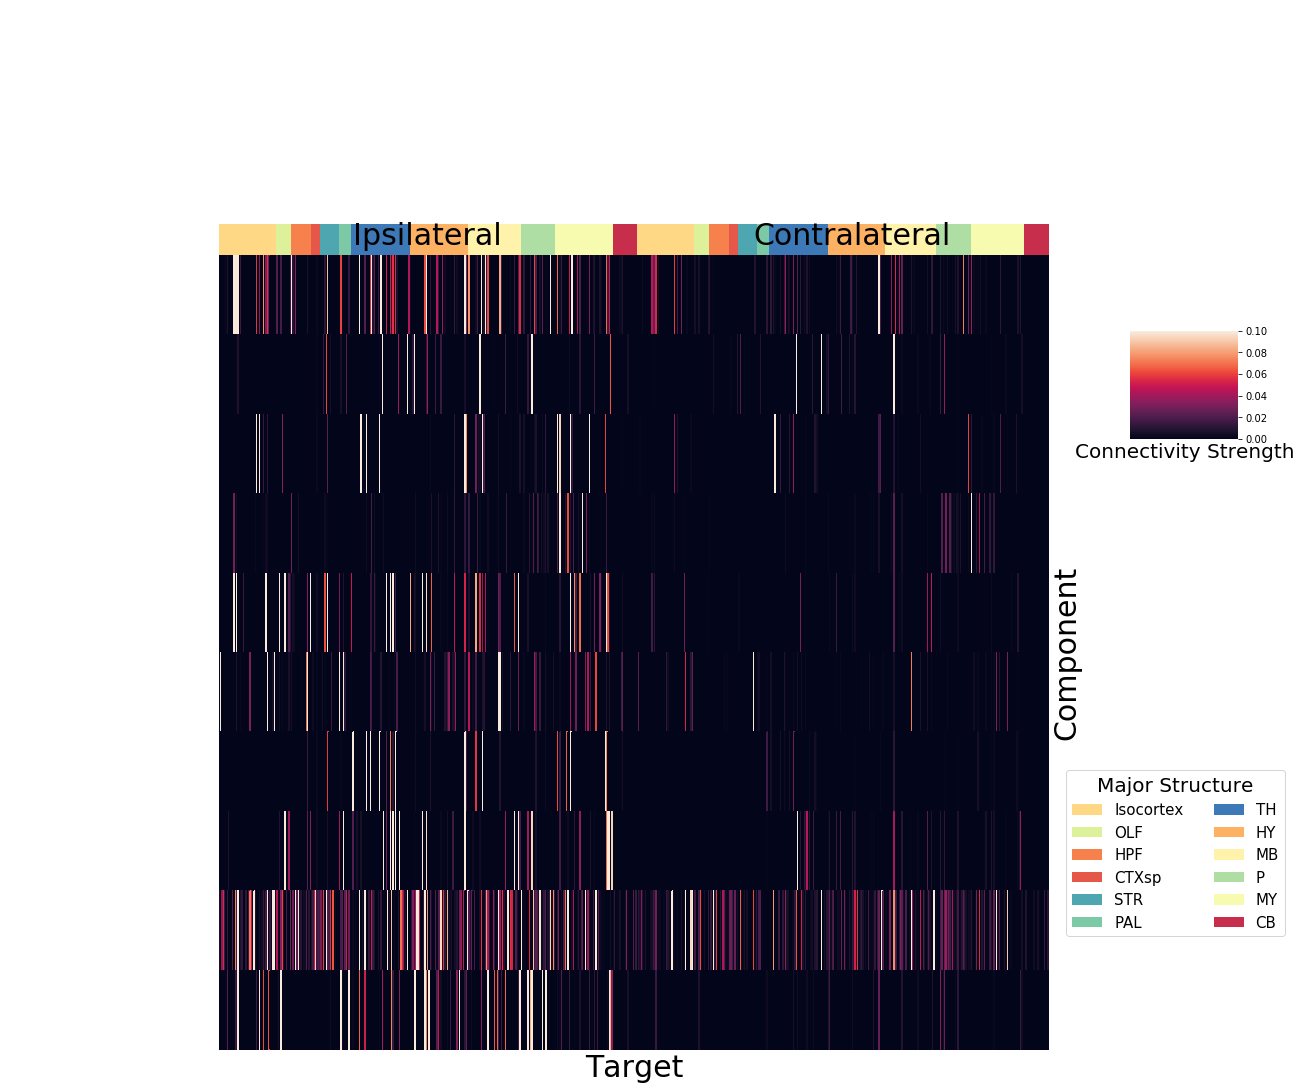

In [91]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(nmf.components_[:10], vmin = 0., vmax = 0.1 , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15))

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.65, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.65, 'Contralateral', fontsize = 30)

ax = gcf().add_axes((0.74,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=2, bbox_to_anchor=(1.2, .3), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Connectivity Strength', rotation=0, fontsize = 20)
g.ax_cbar.set_position([1.05,0.6,.1,.1])

g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
    pad_inches = 0)

In [46]:
nmf.components_[np.where(nmf.components_ < 1e-9)] = np.nan

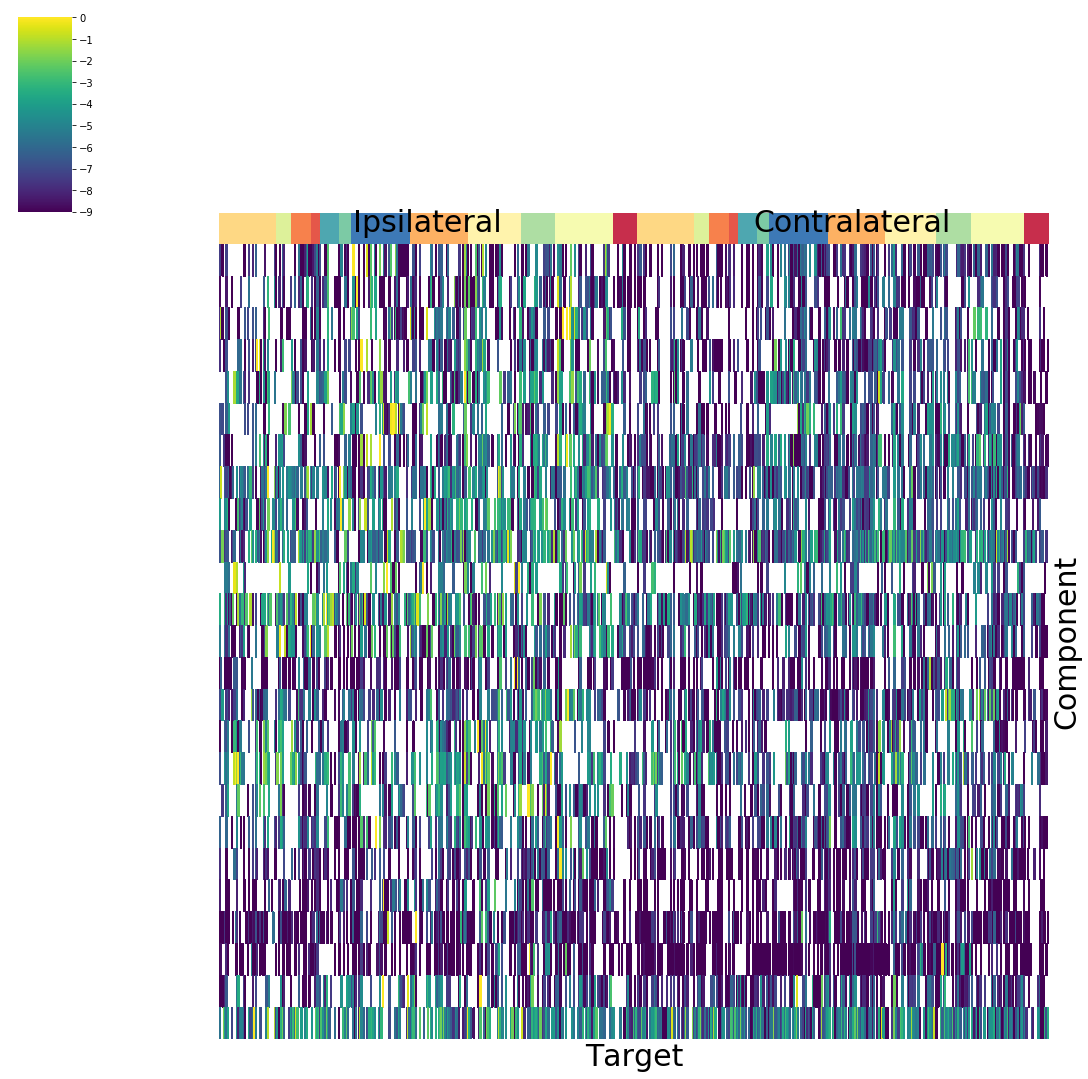

In [47]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(np.log(nmf.components_), vmin = -9, vmax = 0. , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15), cmap = 'viridis')

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.6, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.6, 'Contralateral', fontsize = 30)
g.savefig('/Users/samsonkoelle/nmf_heatmap2.png')

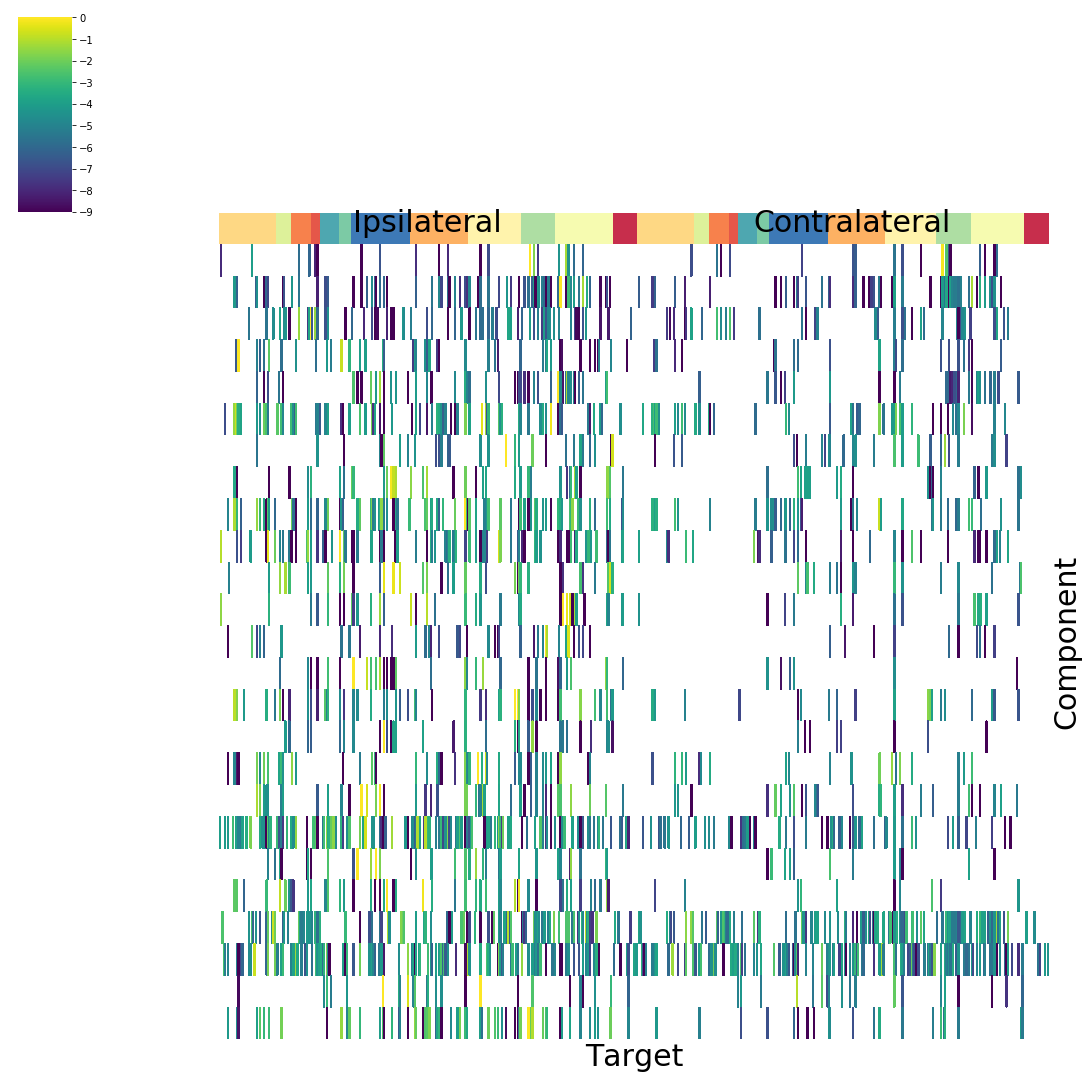

In [43]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(np.log(nmf.components_), vmin = -9, vmax = 0. , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15), cmap = 'viridis')

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.6, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.6, 'Contralateral', fontsize = 30)
g.savefig('/Users/samsonkoelle/nmf_heatmap2.png')

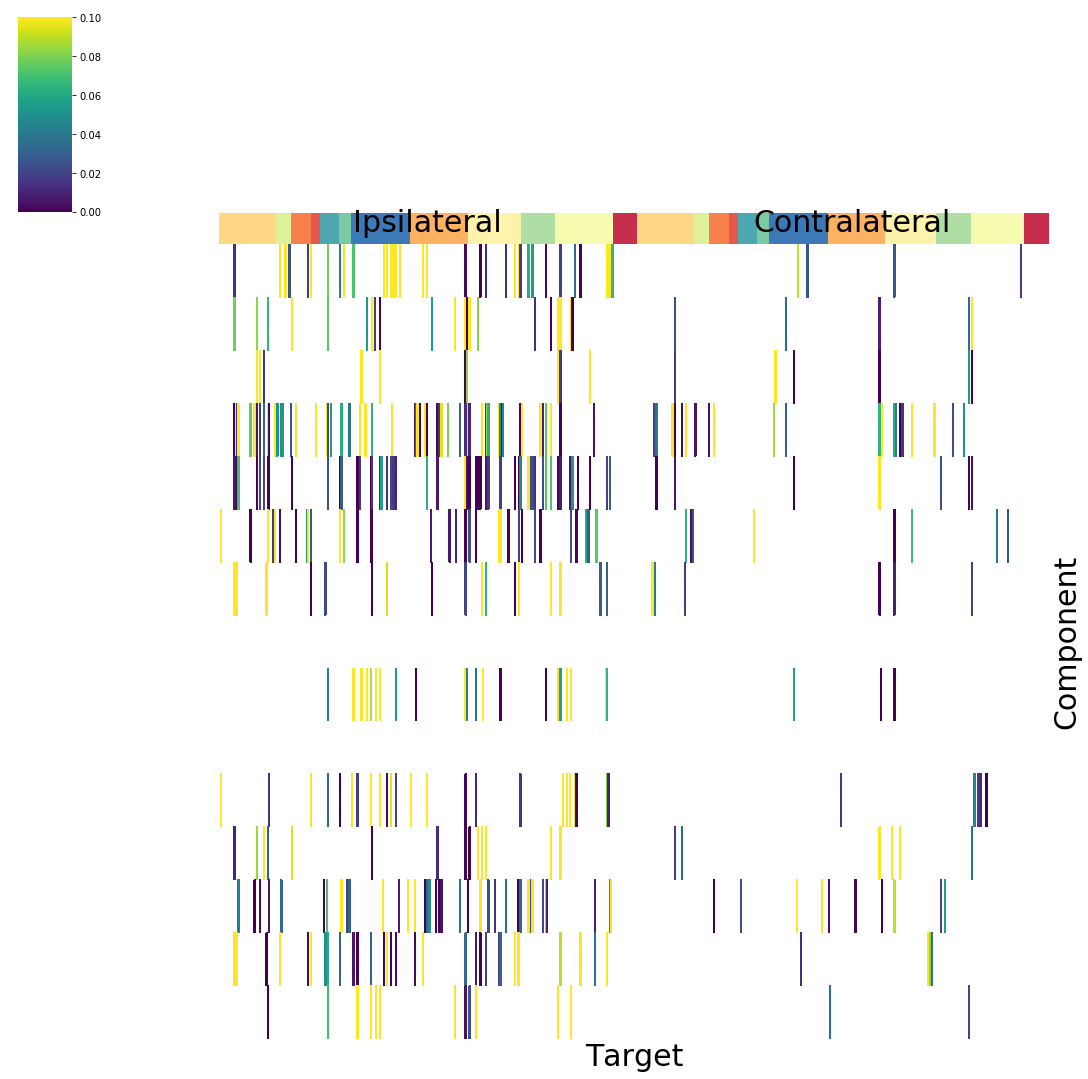

In [179]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(nmf.components_, vmin = 0., vmax = 0.1 , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15), cmap = 'viridis')

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.6, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.6, 'Contralateral', fontsize = 30)
g.savefig('/Users/samsonkoelle/nmf_heatmap2.png')

In [19]:
#np.where(wt_conn.sum(axis =  1) > 0.)[0].shape

In [15]:
# #load data
# #there appears to be an issue with index_col = [0],  header=[0,1]
# wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/ELLeafsmoothleafsurface_summarysource_leaftarget_v3/elleafsurfaceleafsmooth_leafsource_summarytarget_wt_v3.csv',  header=[0,1])

# def fix_pdcsv(csv):
    
#     #wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])
#     csv_rownames = np.asarray(csv.iloc[:,0])
#     csv = csv.iloc[:,1:]
#     csv.index = csv_rownames
#     return(csv)

# wt_conn = fix_pdcsv(wt_conn)